   ----  J. Gair, M. Muratore and L.Speri -----  %% 23-07-2023 %%

# This notebook has the aim of quantify the inpact of noise knowledge uncertainty on parameters estimation of different SGW background models. 

##### - We consider 3 TDI channels A,E and $\zeta$ first generation and only secondary noises such as OMS and Test-Mass acceleration noise. We consider the TM to be correlated among the single link but the OMS to be not correlated. 

##### - The models implemented are First order phase transition, Power law, Power law with running, Gaussian Bump. We include the foreground togheter with the instrumental noise to also show the inpact on parameter estimation. 

##### - in the first part of the analysis we assume a uniform gaussian prior on the noise, in the second part of the analysis we instead vary the prior from very small to big to answer the question if is possible to put requirement on how well we need to know the noise 


## Import packages or pip installed in your environment.

In [169]:


import sys
import scipy

import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings
import mpmath as mp
from numba import njit

from scipy.special import gammainc as gammainc
# Import other packages which are less common and specific to the task at hand.

#from functions import *
import emcee
from scipy.interpolate import CubicSpline
import corner
import multiprocessing as mps
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)

In [170]:
!pip3 install corner

In [171]:
! pip3 install numba

In [172]:
!pip3 install numpy

In [173]:
# Plotting options

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size":15
})

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False

## Here you need to import or compute the tranfer function of the TDI A,E $\zeta$ for stochastic GW background for unequal armlength orbits and isotropic stochastic background uploading the csv file provided or following (https://doi.org/10.48550/arXiv.2303.15929)

In [174]:
## if you upload the files, they are divided in real and immaginary components; and includes the TDI in this order: A,E,zeta,AE,Azeta,Ezeta

## real part ##
TDIcsd_re =np.transpose( np.genfromtxt('/Users/murmar/Documents/workspace/TDItransferfunction_martina_real.csv', delimiter=','))
## immaginary part  ###
TDIcsd_cp = np.transpose(np.genfromtxt('/Users/murmar/Documents/workspace/TDItransferfunction_martina_complex.csv', delimiter=',') )

### Assigning uploaded data to the correct variables

In [175]:
# frequency array 
fpsd= TDIcsd_re[0]
# I need rearrange initial bit of the frequency to be consistent with the knots that we are using. 
fpsdreq=fpsd
# this df is used for the fisher matrix integration
Df= np.diff(fpsdreq)
# this array is used for the fisher matrix as we do not use even spaced frequencies therefore we need to drop the last bit
f_array =  fpsdreq[:599]
# psd A,E and zeta
tf_zeta_sqrt =TDIcsd_re[3]
tf_A_sqrt = TDIcsd_re[1]
tf_E_sqrt = TDIcsd_re[2]
# CSD AE, Azeta, Ezeta
tf_AE_sqrt = TDIcsd_re[4]+1j*TDIcsd_cp[1]
tf_Azeta_sqrt = TDIcsd_re[5]+1j*TDIcsd_cp[2]
tf_Ezeta_sqrt = TDIcsd_re[6]+1j*TDIcsd_cp[3]
## new arrays of transfer function considering the frequency range in accordance to the knowts we are using
tf_psdzeta = tf_zeta_sqrt[:599]
tf_psdA = tf_A_sqrt[:599]
tf_psdE = tf_E_sqrt[:599]
tf_csdAzeta = tf_Azeta_sqrt[:599]
tf_csdEzeta = tf_Ezeta_sqrt[:599]
tf_csdAE = tf_AE_sqrt[:599]


### Time considered for the integration

In [176]:
year= 4
Tobs=year *365*24* 60*60 

# Defining the analytical PSD for the tdi A,E and $\zeta$ first generation; note we assume 6 equal TM and 6 equal oms

In [177]:
#######
def SA1mich_func_unq(f_array):
    delta5 = -0.004859508251784215
    delta6 = 0.009363952212402271
    om = 2 * np.pi* f_array
  #  L = 2.5*10**9   # Length of LISA arm
    c = 299792458 # velocity of light
    T = 8.3
    constant = 1/c**2*om**2
    Soms = (15*10**(-12))**2*(1+(2*10**(-3)/f_array)**4)  # Optical Metrology Sensor
    Sacc = (3*10**(-15))**2*(1+((0.4*10**(-3))/f_array)**2)*(1+(f_array/(8*10**(-3)))**4) *(1/om**4) # Acceleration Noise converted in meter

    return constant*(Soms*(8. + 1.*np.cos((8.3391023799538 + 7.2218745057992635*delta5 - 29.186858329838305*delta6)*om) - 1.*np.cos((25.0173071398614 + 7.2218745057992635*delta5 - 12.5086535699307*delta6)*om) - 4.*np.cos((16.6782047599076 - 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) - 2.*np.cos((16.6782047599076 + 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) + 2.*np.cos((8.3391023799538 - 7.2218745057992635*delta5 - 4.1695511899769*delta6)*om) - 1.*np.cos((8.3391023799538 + 21.66562351739779*delta5 - 4.1695511899769*delta6)*om) - 1.*np.cos((25.0173071398614 - 7.2218745057992635*delta5 + 12.5086535699307*delta6)*om) - 2.*np.cos((16.6782047599076 + 16.6782047599076*delta6)*om) + 1.*np.cos((8.3391023799538 - 21.66562351739779*delta5 + 20.8477559498845*delta6)*om) - 1.*np.cos((8.3391023799538 + 7.2218745057992635*delta5 + 20.8477559498845*delta6)*om)) + Sacc*(24. - 2.*np.cos(28.887498023197054*delta5*om) + 4.*np.cos((8.3391023799538 + 7.2218745057992635*delta5 - 29.186858329838305*delta6)*om) - 2.*np.cos((33.3564095198152 - 16.6782047599076*delta6)*om) - 4.*np.cos((25.0173071398614 + 7.2218745057992635*delta5 - 12.5086535699307*delta6)*om) - 8.*np.cos((16.6782047599076 - 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) - 4.*np.cos((16.6782047599076 + 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) + 8.*np.cos((8.3391023799538 - 7.2218745057992635*delta5 - 4.1695511899769*delta6)*om) - 4.*np.cos((8.3391023799538 + 21.66562351739779*delta5 - 4.1695511899769*delta6)*om) - 2.*np.cos((33.3564095198152 - 14.443749011598527*delta5 + 8.3391023799538*delta6)*om) - 4.*np.cos((25.0173071398614 - 7.2218745057992635*delta5 + 12.5086535699307*delta6)*om) - 4.*np.cos((16.6782047599076 + 16.6782047599076*delta6)*om) + 4.*np.cos((8.3391023799538 - 21.66562351739779*delta5 + 20.8477559498845*delta6)*om) - 4.*np.cos((8.3391023799538 + 7.2218745057992635*delta5 + 20.8477559498845*delta6)*om) - 2.*np.cos(14.443749011598527*delta5*om + 25.0173071398614*delta6*om)))

def SE1mich_func_unq(f_array):
    delta5 = -0.004859508251784215
    delta6 = 0.009363952212402271
    om = 2 * np.pi* f_array
  #  L = 2.5*10**9   # Length of LISA arm
    c = 299792458 # velocity of light
    T = 8.3
    constant = 1/c**2*om**2
    Soms = (15*10**(-12))**2*(1+(2*10**(-3)/f_array)**4)  # Optical Metrology Sensor
    Sacc = (3*10**(-15))**2*(1+((0.4*10**(-3))/f_array)**2)*(1+(f_array/(8*10**(-3)))**4) *(1/om**4) # Acceleration Noise converted in meter

    return (Soms*(8. - 0.6666666666666666*np.cos((25.0173071398614 - 14.443749011598527*delta5)*om) - 0.6666666666666666*np.cos((25.0173071398614 + 14.443749011598527*delta5)*om) + 0.6666666666666666*np.cos((8.3391023799538 - 7.2218745057992635*delta5 - 29.186858329838305*delta6)*om) - 0.3333333333333333*np.cos((8.3391023799538 + 7.2218745057992635*delta5 - 29.186858329838305*delta6)*om) - 0.6666666666666666*np.cos((8.3391023799538 - 14.443749011598527*delta5 - 16.6782047599076*delta6)*om) - 0.6666666666666666*np.cos((8.3391023799538 + 14.443749011598527*delta5 - 16.6782047599076*delta6)*om) - 0.6666666666666666*np.cos((25.0173071398614 - 7.2218745057992635*delta5 - 12.5086535699307*delta6)*om) + 0.3333333333333333*np.cos((25.0173071398614 + 7.2218745057992635*delta5 - 12.5086535699307*delta6)*om) - 1.3333333333333333*np.cos((16.6782047599076 - 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) - 3.333333333333333*np.cos((16.6782047599076 + 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) - 0.6666666666666666*np.cos((8.3391023799538 - 21.66562351739779*delta5 - 4.1695511899769*delta6)*om) - 0.6666666666666666*np.cos((8.3391023799538 - 7.2218745057992635*delta5 - 4.1695511899769*delta6)*om) + 1.3333333333333333*np.cos((8.3391023799538 + 7.2218745057992635*delta5 - 4.1695511899769*delta6)*om) + 0.3333333333333333*np.cos((8.3391023799538 + 21.66562351739779*delta5 - 4.1695511899769*delta6)*om) + 1.3333333333333333*np.cos((8.3391023799538 + 8.3391023799538*delta6)*om) + 0.6666666666666666*np.cos((8.3391023799538 - 28.887498023197054*delta5 + 8.3391023799538*delta6)*om) + 0.6666666666666666*np.cos((8.3391023799538 + 28.887498023197054*delta5 + 8.3391023799538*delta6)*om) + 0.3333333333333333*np.cos((25.0173071398614 - 7.2218745057992635*delta5 + 12.5086535699307*delta6)*om) - 0.6666666666666666*np.cos((25.0173071398614 + 7.2218745057992635*delta5 + 12.5086535699307*delta6)*om) - 3.3333333333333335*np.cos((16.6782047599076 + 16.6782047599076*delta6)*om) - 0.3333333333333333*np.cos((8.3391023799538 - 21.66562351739779*delta5 + 20.8477559498845*delta6)*om) - 0.6666666666666666*np.cos((8.3391023799538 - 7.2218745057992635*delta5 + 20.8477559498845*delta6)*om) + 0.3333333333333333*np.cos((8.3391023799538 + 7.2218745057992635*delta5 + 20.8477559498845*delta6)*om) + 0.6666666666666666*np.cos((8.3391023799538 + 21.66562351739779*delta5 + 20.8477559498845*delta6)*om)) + Sacc*(24. - 2.6666666666666665*np.cos((25.0173071398614 - 14.443749011598527*delta5)*om) - 0.6666666666666666*np.cos(28.887498023197054*delta5*om) - 2.6666666666666665*np.cos((25.0173071398614 + 14.443749011598527*delta5)*om) + 2.6666666666666665*np.cos((8.3391023799538 - 7.2218745057992635*delta5 - 29.186858329838305*delta6)*om) - 1.3333333333333333*np.cos((8.3391023799538 + 7.2218745057992635*delta5 - 29.186858329838305*delta6)*om) - 0.6666666666666666*np.cos((33.3564095198152 - 16.6782047599076*delta6)*om) - 2.6666666666666665*np.cos((8.3391023799538 - 14.443749011598527*delta5 - 16.6782047599076*delta6)*om) - 2.6666666666666665*np.cos((8.3391023799538 + 14.443749011598527*delta5 - 16.6782047599076*delta6)*om) - 2.6666666666666665*np.cos((25.0173071398614 - 7.2218745057992635*delta5 - 12.5086535699307*delta6)*om) + 1.3333333333333333*np.cos((25.0173071398614 + 7.2218745057992635*delta5 - 12.5086535699307*delta6)*om) - 2.6666666666666665*np.cos((16.6782047599076 - 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) - 6.666666666666666*np.cos((16.6782047599076 + 14.443749011598527*delta5 - 8.3391023799538*delta6)*om) - 2.6666666666666665*np.cos((8.3391023799538 - 21.66562351739779*delta5 - 4.1695511899769*delta6)*om) - 2.6666666666666665*np.cos((8.3391023799538 - 7.2218745057992635*delta5 - 4.1695511899769*delta6)*om) + 5.333333333333333*np.cos((8.3391023799538 + 7.2218745057992635*delta5 - 4.1695511899769*delta6)*om) + 1.3333333333333333*np.cos((8.3391023799538 + 21.66562351739779*delta5 - 4.1695511899769*delta6)*om) + 5.333333333333333*np.cos((8.3391023799538 + 8.3391023799538*delta6)*om) + 2.6666666666666665*np.cos((8.3391023799538 - 28.887498023197054*delta5 + 8.3391023799538*delta6)*om) - 0.6666666666666666*np.cos((33.3564095198152 - 14.443749011598527*delta5 + 8.3391023799538*delta6)*om) - 2.6666666666666665*np.cos((33.3564095198152 + 14.443749011598527*delta5 + 8.3391023799538*delta6)*om) + 2.6666666666666665*np.cos((8.3391023799538 + 28.887498023197054*delta5 + 8.3391023799538*delta6)*om) + 1.3333333333333333*np.cos((25.0173071398614 - 7.2218745057992635*delta5 + 12.5086535699307*delta6)*om) - 2.6666666666666665*np.cos((25.0173071398614 + 7.2218745057992635*delta5 + 12.5086535699307*delta6)*om) - 6.666666666666666*np.cos((16.6782047599076 + 16.6782047599076*delta6)*om) - 1.3333333333333333*np.cos((8.3391023799538 - 21.66562351739779*delta5 + 20.8477559498845*delta6)*om) - 2.6666666666666665*np.cos((8.3391023799538 - 7.2218745057992635*delta5 + 20.8477559498845*delta6)*om) + 1.3333333333333333*np.cos((8.3391023799538 + 7.2218745057992635*delta5 + 20.8477559498845*delta6)*om) + 2.6666666666666665*np.cos((8.3391023799538 + 21.66562351739779*delta5 + 20.8477559498845*delta6)*om) - 2.666666666666667*np.cos(14.443749011598527*delta5*om - 25.0173071398614*delta6*om) - 0.666666666666667*np.cos(14.443749011598527*delta5*om + 25.0173071398614*delta6*om)))*constant

def Szeta1_func_unq(f_array):
    delta5 = -0.004859508251784215
    delta6 = 0.009363952212402271
    om = 2 * np.pi* f_array
#    L = 2.5*10**9   # Length of LISA arm
    c = 299792458 # velocity of light
    T = 8.3
    constant = 1/c**2*om**2
    Soms = (15*10**(-12))**2*(1+(2*10**(-3)/f_array)**4)  # Optical Metrology Sensor
    Sacc = (3*10**(-15))**2*(1+((0.4*10**(-3))/f_array)**2)*(1+(f_array/(8*10**(-3)))**4) *(1/om**4) # Acceleration Noise converted in meter

    return  (6.*Soms + Sacc*(12. - 4.*np.cos((8.3391023799538 - 16.6782047599076*delta6)*om) - 4.*np.cos((8.3391023799538 - 14.443749011598527*delta5 + 8.3391023799538*delta6)*om) - 4.*np.cos((8.3391023799538 + 14.443749011598527*delta5 + 8.3391023799538*delta6)*om))
            )*constant


# Defining the 4 SGWB models

## Constant parameters 

In [178]:
Nch = 3  # number of channels

B = 7.98 * 10**(-37) # transformation constant correpsonds to 100 km/s/Mpc

Ho =2.1970187945560596e-18 # hubble constant 67.8 km/s/Mpc

f1mhz=0.001 

hz=0.678

np.cost = 4/3 * np.pi**2/Ho**2 *  B  # convertion factor to get the psds. This is 1/hz^2!!!

## Astrophysical SGWB in the LISA band: the one from GBs.

In [179]:
Amp_GB = 1.15*10**(-44)
n_GB = 7/3
alpha_GB = 1.56
a1 = -0.15
b1 = -2.72
ak= -0.37
bk = -2.49
f2 = 6.7*10**(-4)
f1 = 10**(a1*np.log10(year)+b1)
fknee = 10**(ak*np.log10(year)+bk)

S_GB =  Amp_GB *(f_array)**(-n_GB)*np.exp(-(f_array/f1)**alpha_GB) *1/2*(1 + np.tanh((fknee-f_array)/f2))   

## Power law 

In [185]:
n_pl = 2/3 
Amp_pl = 7.87*10**(-13)
fp_pl =  0.003

Amp_c_pl =  B  *  Amp_pl ## amplitude

h2OMEGAsBHB = Amp_pl *(f_array/fp_pl)**n_pl ## energy density

S_pl = B /f_array**3 *h2OMEGAsBHB

## power law  with running 


In [186]:
n_pl_wr = 1
alpha_pl_wr = -0.1
A_pl_wr =  -12.65
fp_pl_wr =  0.003

h2OMEGA_pl_wr = 10**A_pl_wr *(f_array/fp_pl_wr)**(n_pl_wr+alpha_pl_wr *np.log(f_array/fp_pl_wr))

S_pl_wr  = B /f_array**3 *h2OMEGA_pl_wr 
Amp_pl_wr =  B  * 10**A_pl_wr

## Gaussian bump 


In [187]:
sigma = 0.3
A_gaussian =  -12.48
fp_gaussian =  0.003

Amp_gaussian =  B  * 10**A_gaussian ## amplide

h2OMEGA_gaussian = 10**A_gaussian *np.exp(-1/(2*sigma**2)*np.log(f_array/fp_gaussian )**2) ## energy density

S_gaussian  = B /f_array**3 *h2OMEGA_gaussian

## First order Phase transition 

In [188]:
### parameter

n_FOPT = 7/2
A_FOPT =  (-10)
fp_FOPT = 2*10**(-4)

Amp_FOPT=  B * 10 ** A_FOPT  ## amplitude

h2OMEGA_FOPT = 10** A_FOPT *(f_array/fp_FOPT)**3 * (7 /(4 + 3 *(f_array/fp_FOPT)**2) ) ** n_FOPT

S_FOPT = B /f_array**3 *h2OMEGA_FOPT

# Noise PDS and SGWB models 

## Computation of the SNR from eq 36 of (https://journals.aps.org/prd/pdf/10.1103/PhysRevD.88.124032)

In [189]:
SNRA_GB  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_GB* tf_psdA)**2/SAm**2*(f_array)* np.diff(np.log(f_array))[0] ))
SNRA_pl  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_pl* tf_psdA)**2/SAm**2*(f_array)* np.diff(np.log(f_array))[0] ))
SNRA_pl_wr  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_pl_wr* tf_psdA)**2/SAm**2*(f_array)* np.diff(np.log(f_array))[0] ))
SNRA_gaussian  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_gaussian* tf_psdA)**2/SAm**2*(f_array)* np.diff(np.log(f_array))[0] ))
SNRA_FOPT  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_FOPT* tf_psdA)**2/SAm**2*(f_array)* np.diff(np.log(f_array))[0] ))

In [190]:

SNRA_pl_GB  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_pl* tf_psdA)**2/(SAm+S_GB* tf_psdA)**2*(f_array)* np.diff(np.log(f_array))[0] ))
SNRA_pl_wr_GB  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_pl_wr* tf_psdA)**2/(SAm+S_GB* tf_psdA)**2*(f_array)* np.diff(np.log(f_array))[0] ))
SNRA_gaussian_GB  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_gaussian* tf_psdA)**2/(SAm+S_GB* tf_psdA)**2*(f_array)* np.diff(np.log(f_array))[0] ))
SNRA_FOPT_GB  =  np.sqrt(Tobs) * np.sqrt(np.sum((S_FOPT* tf_psdA)**2/(SAm+S_GB* tf_psdA)**2*(f_array)* np.diff(np.log(f_array))[0] ))

In [192]:
print('SNRA_GB:',SNRA_GB) 
print('Power law with running SNR:',SNRA_pl_wr,'Power law with running SNR with GB:',SNRA_pl_wr_GB )
print('Power law SNR:',SNRA_pl,'Power law SNR with GB :',SNRA_pl_GB)
print('Gaussian bump SNR:',SNRA_gaussian,'Gaussian bump SNR with GB:',SNRA_gaussian_GB)
print('First order phase transition SNR:',SNRA_FOPT,'First order phase transition SNR with GB:',SNRA_FOPT_GB)

SNRA_GB: 1627.3955188531856
Power law with running SNR: 14.53942817562623 Power law with running SNR with GB: 13.347937277657037
Power law SNR: 48.69686720333783 Power law SNR with GB : 42.89280292705415
Gaussian bump SNR: 13.508153815024256 Gaussian bump SNR with GB: 11.642372970776998
First order phase transition SNR: 118.68207259343346 First order phase transition SNR with GB: 64.17893926577166


# Plotting the PSD of TDI A with the different signal modesl

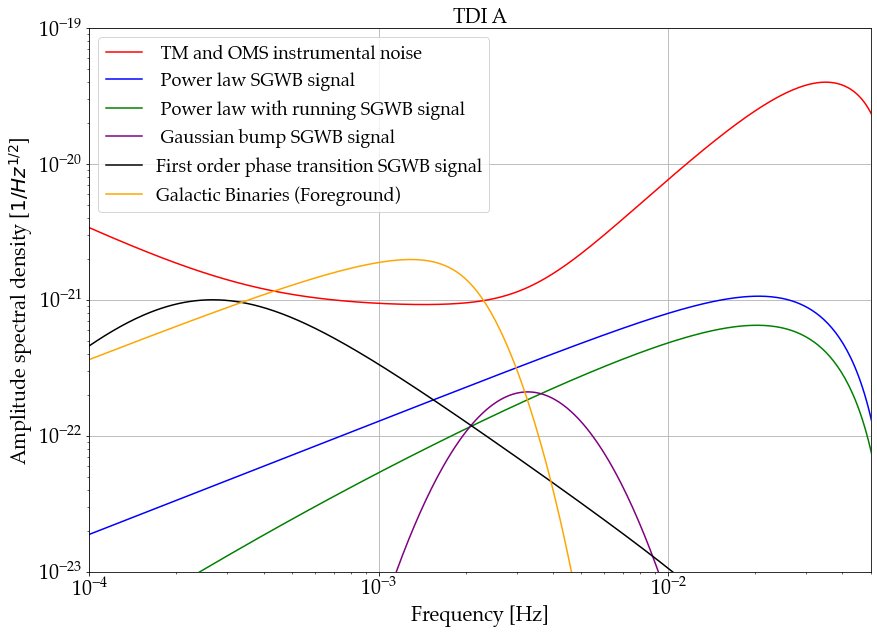

In [194]:
plt.figure(figsize=(14, 10))
plt.title(' TDI A ', fontsize=20)
plt.loglog(f_array,  np.sqrt(SAm ), '-', color='red', label=' TM and OMS instrumental noise ')
plt.loglog(f_array, np.sqrt(S_pl * tf_psdA ), '-', color='blue', label=' Power law SGWB signal ')
plt.loglog(f_array, np.sqrt(S_pl_wr * tf_psdA), '-', color='green', label=' Power law with running SGWB signal ')
plt.loglog(f_array, np.sqrt(S_gaussian * tf_psdA ), '-', color='purple', label=' Gaussian bump SGWB signal ')
plt.loglog(f_array, np.sqrt(S_FOPT *tf_psdA ), '-', color='black', label='First order phase transition SGWB signal')
plt.loglog(f_array, np.sqrt(S_GB *tf_psdA ), '-', color='orange', label='Galactic Binaries (Foreground)')
#plt.loglog(f_array, np.sqrt( SA1s)/c*om, '.-', color='green', label=' secondary noises A Sagnac ')
#plt.loglog(f_array, np.sqrt(  SE1s)/c*om, '-', color='blue', label=' secondary noises E Sagnac ')
plt.xlabel('Frequency [Hz]', fontsize=20)
plt.ylabel('Amplitude spectral density [$1/Hz^{1/2}$]', fontsize=20)
plt.xlim([1e-4, 5*0.01])
plt.ylim([1e-23, 1e-19])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.grid(True)
plt.legend(fontsize=18)

# Splines models

We write a python function  that defines a cubic spline model for mimic noise knowledge uncertainty in the noise. Here's what each of the arguments and the function body does:

### Arguments:

logf_knots: a 1D array knots in log10 at which the spline knots are placed
spline_pars: a 1D array of the spline coefficients for each interval between the knots (setting the spline weights) 
f_array: a 1D array of the frequencies at which the PSD will be calculated

### Function Body:


noise_uncert is a cubic spline interpolation function that takes in the logf_knots and spline_pars as arguments, and returns a function that can be used to evaluate the spline at any desired frequency.
modnoisevar = Exp[noise_uncert] is an array of the PSD values at each frequency in f_array, calculated by exponentiating the spline values returned by noise_uncert and scaling by a factor of log(10) to convert from base-10 logarithmic units to natural logarithmic units.

### outputs 

The function returns the modnoisevar array of PSD values.

## Defining the knots and spline weights

In [193]:
# we consider 13 equally space knots to allow for a sufficient slowly varing PDS

logf_knots = np.array([-4,-3.67,-3.33,-3,-2.67,-2.33,-2,-1.67,-1.33,-1,-0.67,-0.33,0])

# we consider here the weight of the spline, the weight of the splines are zeros this means we refer to the reference value of the psd
ref_weights = np.zeros(len(logf_knots),dtype=np.cdouble)

Ncov=np.int32(Nch*(Nch+1)/2)  
Nch*Nch
spline_weights_csd = np.zeros((Nch*Nch,len(logf_knots)),dtype=np.cdouble)
for i in range(Nch*Nch):
    spline_weights_csd[i,]=ref_weights

## Define spline model

In [195]:
def spline_psd_mod(logf_knots,spline_pars,f_array):
    noise_uncert=CubicSpline(logf_knots, spline_pars,bc_type='natural')
    modnoisevar=np.exp(np.log(10.0)*noise_uncert(np.log10(f_array)))
    return(modnoisevar)

### Plot some example PSDs drawn from the spline model

Text(0, 0.5, '$S_h(f)/S_{design}(f)$')

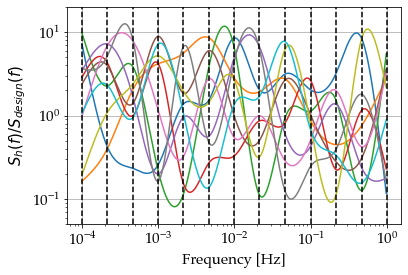

In [196]:
for i in range(10):
    
    noise_uncert_weights=np.random.uniform(-1,1,size=len(logf_knots)) #-3.0+4.0*np.random.random(len(logf_knots))
    # noise_uncert_weights=np.random.normal(0.0,10**-3,len(logf_knots))
    noise_uncert=spline_psd_mod(logf_knots,noise_uncert_weights,f_array)
    plt.loglog(f_array,noise_uncert,'-',alpha=1)
plt.axvline(x=1.e-4,c='k',ls='--')
plt.axvline(x=10**-3.67,c='k',ls='--')
plt.axvline(x=10**-3.33,c='k',ls='--')
plt.axvline(x=1e-3,c='k',ls='--')
plt.axvline(x=10**-2.67,c='k',ls='--')
plt.axvline(x=10**-2.33,c='k',ls='--')
plt.axvline(x=1e-2,c='k',ls='--')
plt.axvline(x=10**-1.67,c='k',ls='--')
plt.axvline(x=10**-1.33,c='k',ls='--')
plt.axvline(x=1e-1,c='k',ls='--')
plt.axvline(x=10**-0.67,c='k',ls='--')
plt.axvline(x=10**-0.33,c='k',ls='--')
plt.axvline(x=1,c='k',ls='--')
plt.ylim([5e-2 , 2e1])
plt.grid()
plt.xlabel('Frequency [Hz]')
plt.ylabel('$S_h(f)/S_{design}(f)$')


# Fisher matrix computation

In [197]:
@njit

def JointFisherMatrix(dSdpar_src,dSdpar_inst,PSD_inv,prior_inv,Nch):
    
    Ncov=np.int(Nch*(Nch+1)/2) # number of channels 
    Nf=np.shape(PSD_inv)[0] # frequency bins 
    Nsrc=np.shape(dSdpar_src)[0] # number of parameters for the sources
    Ninst=np.shape(dSdpar_inst)[0] # number of parameters for the instrument (+ 1 parameter for GB --optional--)
    FM_ref=np.zeros(shape=(Nsrc,Nsrc),dtype=np.cdouble)  # fisher for the sources 
    FM_full=np.zeros(shape=(Ninst+Nsrc,Ninst+Nsrc),dtype=np.cdouble) # fisher for the total parameter
    
    all_derivs=np.concatenate((dSdpar_src,dSdpar_inst),axis=0) # adding all the derivative togheter 
    
    this_FM=np.zeros(shape=(Ninst+Nsrc,Ninst+Nsrc),dtype=np.cdouble) # fisher total parameters 
    this_PSD=np.zeros(shape=(Nch,Nch),dtype= np.cdouble) # PSD matrix 
    this_derivI=np.zeros(shape=(Nch,Nch),dtype= np.cdouble) # first derivative to build the fisher (eq. 10) the deriv are computed with respect to the parameters but have dimension of the covariance matrix 
    this_derivII=np.zeros(shape=(Nch,Nch),dtype= np.cdouble) # second derivative to build the fisher (eq.10) the deriv are computed with respect to the parameters but have dimension of the covariance matrix 

    for i in range(Nf): # summing over frequencies
        this_FM.fill(0) # you set to zero this matrix that you will fill in later
        ct=0 
        for j in range(Nch):   # j and k run over the detectors indexes
            for k in range(j,Nch):
                this_PSD[j,k]=PSD_inv[i,ct]  # we need to compute the inverse of the cov matrix, the inv is computed considering freq and detectors index ct
                this_PSD[k,j]= np.conj(this_PSD[j,k]) # we consider the matrix to be simmetric
                ct+=1
        for j in range(Nsrc+Ninst): # we need now to compute the derivatives with respect to the parameters
            ct=0
            for l in range(Nch):
                for m in range(l,Nch):
                    this_derivI[l,m]=all_derivs[j,i,ct] # take the element ct in the flat array (all_derivates) for each frequency and considering the correct detector ij
                    this_derivI[m,l]=np.conj(this_derivI[l,m])
                    ct+=1
            for k in range(Nsrc+Ninst):
                ct=0
                for l in range(Nch):
                    for m in range(l,Nch):
                        this_derivII[l,m]=all_derivs[k,i,ct]
                        this_derivII[m,l]=np.conj(this_derivII[l,m])
                        ct+=1
                integ_matrix = (this_PSD @ (this_derivI @ (this_PSD @ this_derivII)))
                this_FM[j,k]=np.trace(integ_matrix) 
                this_FM[k,j]=this_FM[j,k]
        this_FM_real=np.real(this_FM) # we saw that the immaginary part come from numerical issue this is why we only take the real part 
        FM_full+=this_FM_real* Df[i]*Tobs 
      
    # Incorporate prior
    FM_full+=prior_inv   # we uncorporate uniform prior 
    FM_ref=FM_full[:Nsrc,:Nsrc] # here we consider the component of the fisher of the signal 
    
    # Compute inverses   
    fish_ref = FM_ref.copy() 
    fish_ref_inv = np.linalg.inv(fish_ref)
    fish_full = FM_full.copy()
    fish_full_inv = np.linalg.inv(fish_full)
    
    # Compute ratio of estimated precisions
    ratiores=np.zeros(Nsrc,dtype= np.cdouble)
    for i in range(Nsrc):
        ratiores[i]=np.sqrt(fish_full_inv[i,i]/fish_ref_inv[i,i]) # here we compute the ration b/w full and ref matrix to quantify the error due to noise uncertainty
        
    return(FM_ref,FM_full,fish_ref_inv,fish_full_inv,ratiores)


## Subroutine to invert PSD.


In [198]:
# It reconstructs the full matrix from the upper diagonal part, which we have  stored, and then inverts it.
@njit

def MakePSDInv(PSD,Nch):
    Ncov=np.int(Nch*(Nch+1)/2)
    Nf=np.shape(PSD)[0]
    thismat=np.zeros((Nch,Nch),dtype=np.cdouble)
    PSDinv=np.zeros((Nf,Ncov),dtype=np.cdouble)
    for i in range(Nf):
        ct=0
        for j in range(Nch):
            for k in range(j,Nch):
                thismat[j,k]=PSD[i,ct]
                thismat[k,j]=np.conj(thismat[j,k])
                ct+=1
        thisinv =  np.linalg.pinv(thismat) 
        ct=0 
        for j in range(Nch):
            for k in range(j,Nch):
                PSDinv[i,ct]=thisinv[j,k]
                ct+=1
    return(PSDinv)

# PSD and CSD of Background models and corresponding derivative with respect to the parameters we want to estimate

In [199]:
class BackGround_uneq():
    def __init__(self, f_array, tf_psdA, tf_psdE, tf_psdzeta,tf_csdAE, tf_csdAzeta, tf_csdEzeta,Nch,fp_pl,fp_pl_wr,fp_gaussian,fp_FOPT, f1  ,  fknee ,  f2 , b1 , bk ,alpha_GB,a1, ak,  n_GB):
    #these are all the constant value or the transfer fuctions that are pre-computed globaly defined
        self.tf_psdA = tf_psdA
        self.tf_psdE = tf_psdE
        self.tf_psdzeta = tf_psdzeta
        self.tf_csdAE = tf_csdAE
        self.tf_csdAzeta = tf_csdAzeta
        self.tf_csdEzeta = tf_csdEzeta
        self.f_array = f_array
        self.Nch = Nch
        self.fp_pl = fp_pl
        self.fp_pl_wr = fp_pl_wr
        self.fp_gaussian = fp_gaussian
        self.fp_FOPT = fp_FOPT
        self.f1 = f1
        self.f2 = f2
        self.fknee = fknee
        self.b1 = b1
        self.bk = bk
        self.a1 = a1
        self.ak = ak
        self.alpha_GB = alpha_GB
        self.n_GB = n_GB
        

    def SGWB_powerlaw_Derivs(self, GWB_pars):
        fp =self.fp_pl
        Ncov=np.int32(self.Nch*(self.Nch+1)/2)
        PSD=np.zeros((len(f_array),Ncov),dtype=np.cdouble)
        
        # power specral density and cross spectral density of the TDI channels A,E,zeta,AE,Azeta,Ezeta
        GWBA1=np.exp(GWB_pars[0])*self.f_array**(GWB_pars[1]-3)  *self.tf_psdA /fp**GWB_pars[1]  
        GWBE1=np.exp(GWB_pars[0])*self.f_array**(GWB_pars[1]-3)   *self.tf_psdE /fp**GWB_pars[1]  
        GWBzeta1=np.exp(GWB_pars[0])*self.f_array**(GWB_pars[1]-3) * self.tf_psdzeta /fp**GWB_pars[1]  
        GWBAE1=np.exp(GWB_pars[0])*self.f_array**(GWB_pars[1]-3)  *self.tf_csdAE /fp**GWB_pars[1]  
        GWBAzeta1=np.exp(GWB_pars[0])*self.f_array**(GWB_pars[1]-3)   *self.tf_csdAzeta /fp**GWB_pars[1]  
        GWBEzeta1=np.exp(GWB_pars[0])*self.f_array**(GWB_pars[1]-3) * self.tf_csdEzeta /fp**GWB_pars[1] 
        PSD[:,0]=GWBA1
        PSD[:,1]=GWBAE1
        PSD[:,2]=GWBAzeta1
        PSD[:,3]=GWBE1
        PSD[:,4]=GWBEzeta1
        PSD[:,5]=GWBzeta1
        
        # derivative with respect to amplitude and slope
        dSdpar=np.zeros((len(GWB_pars),len(f_array),Ncov),dtype=np.cdouble)
        dSdpar[0,:,0]=GWBA1
        dSdpar[1,:,0]=GWBA1*(np.log(self.f_array) - np.log(fp))
        
        dSdpar[0,:,1]=GWBAE1
        dSdpar[1,:,1]=GWBAE1*(np.log(self.f_array) - np.log(fp))
        
        dSdpar[0,:,2]=GWBAzeta1
        dSdpar[1,:,2]=GWBAzeta1*(np.log(self.f_array) - np.log(fp))
        
        dSdpar[0,:,3]=GWBE1
        dSdpar[1,:,3]=GWBE1*(np.log(self.f_array) - np.log(fp))
        
        dSdpar[0,:,4]=GWBEzeta1
        dSdpar[1,:,4]=GWBEzeta1*(np.log(self.f_array) - np.log(fp))
        
        dSdpar[0,:,5]=GWBzeta1
        dSdpar[1,:,5]=GWBzeta1*(np.log(self.f_array) - np.log(fp))
        return(PSD,dSdpar)



    def SGWB_Powerlaw_with_running_Derivs(self,GWB_pars):
        fp = self.fp_pl_wr
        Ncov=np.int32(Nch*(Nch+1)/2)
        PSD=np.zeros((len(self.f_array),Ncov),dtype=np.cdouble)
        
        # power specral density and cross spectral density of the TDI channels A,E,zeta
        GWB=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))
        GWBA1=GWB*tf_psdA
        GWBE1=GWB*tf_psdE
        GWBzeta1=GWB*tf_psdzeta
        GWBAE1=GWB*tf_csdAE
        GWBAzeta1=GWB*tf_csdAzeta
        GWBEzeta1=GWB*tf_csdEzeta
        PSD[:,0]=GWBA1
        PSD[:,3]=GWBE1
        PSD[:,5]=GWBzeta1
        PSD[:,1]=GWBAE1
        PSD[:,2]=GWBAzeta1
        PSD[:,4]=GWBEzeta1
        
        # derivative with respect to amplitude and slope and alpha
        dSdpar=np.zeros((len(GWB_pars),len(self.f_array),Ncov),dtype=np.cdouble)
        dSdpar[0,:,0]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_psdA
        dSdpar[1,:,0]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))*self.tf_psdA* ( np.log(self.f_array) +  np.log(1/fp)  ) 
        dSdpar[2,:,0]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))*self.tf_psdA* ( np.log(self.f_array) +  np.log(1/fp)  ) *np.log(self.f_array/fp)
        
        dSdpar[0,:,1]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_csdAE
        dSdpar[1,:,1]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))*self.tf_csdAE* ( np.log(self.f_array) +  np.log(1/fp)  ) 
        dSdpar[2,:,1]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))*self.tf_csdAE* ( np.log(self.f_array) +  np.log(1/fp)  ) *np.log(self.f_array/fp)

        dSdpar[0,:,2]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_csdEzeta
        dSdpar[1,:,2]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))*self.tf_csdEzeta* ( np.log(self.f_array) +  np.log(1/fp)  ) 
        dSdpar[2,:,2]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))*self.tf_csdEzeta* ( np.log(self.f_array) +  np.log(1/fp)  ) *np.log(self.f_array/fp)

        dSdpar[0,:,3]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_psdE
        dSdpar[1,:,3]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_psdE*( np.log(self.f_array) +  np.log(1/fp)  ) 
        dSdpar[2,:,3]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_psdE* ( np.log(self.f_array) +  np.log(1/fp)  ) *np.log(self.f_array/fp)
        
        
        dSdpar[0,:,4]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_csdEzeta
        dSdpar[1,:,4]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_csdEzeta*( np.log(self.f_array) +  np.log(1/fp)  ) 
        dSdpar[2,:,4]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_csdEzeta* ( np.log(self.f_array) +  np.log(1/fp)  ) *np.log(self.f_array/fp)
   
        dSdpar[0,:,5]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_psdzeta
        dSdpar[1,:,5]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)) *self.tf_psdzeta*( np.log(self.f_array) +  np.log(1/fp)  ) 
        dSdpar[2,:,5]=np.exp(GWB_pars[0])*(self.f_array**(-3+GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp)))*(1/fp)**(GWB_pars[1]+GWB_pars[2]*np.log(self.f_array/fp))*self.tf_psdzeta* ( np.log(self.f_array) +  np.log(1/fp)  ) *np.log(self.f_array/fp)
        return(PSD,dSdpar)


    def SGWB_gaussian_bump_Derivs(self,GWB_pars):
        fp = self.fp_gaussian
        Ncov=np.int32(Nch*(Nch+1)/2)
        PSD=np.zeros((len(self.f_array),Ncov),dtype=np.cdouble)
        
        # power specral density and cross spectral density of the TDI channels A,E,zeta
        GWB=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))  
        GWBA1=GWB*tf_psdA
        GWBE1=GWB*tf_psdE
        GWBzeta1=GWB*tf_psdzeta
        GWBAE1=GWB*tf_csdAE
        GWBAzeta1=GWB*tf_csdAzeta
        GWBEzeta1=GWB*tf_csdEzeta
        PSD[:,0]=GWBA1
        PSD[:,3]=GWBE1
        PSD[:,5]=GWBzeta1
        PSD[:,1]=GWBAE1
        PSD[:,2]=GWBAzeta1
        PSD[:,4]=GWBEzeta1
        
        # derivative with respect to amplitude and sigma
        dSdpar=np.zeros((len(GWB_pars),len(self.f_array),Ncov),dtype=np.cdouble)
        dSdpar[0,:,0]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_psdA
        dSdpar[1,:,0]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_psdA*np.log(self.f_array/fp)**2/(GWB_pars[1]**3)
       
        dSdpar[0,:,1]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_csdAE
        dSdpar[1,:,1]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_csdAE*np.log(self.f_array/fp)**2/(GWB_pars[1]**3)
    
        dSdpar[0,:,2]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_csdAzeta
        dSdpar[1,:,2]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_csdAzeta*np.log(self.f_array/fp)**2/(GWB_pars[1]**3)
    
        dSdpar[0,:,3]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_psdE
        dSdpar[1,:,3]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_psdE*np.log(self.f_array/fp)**2/(GWB_pars[1]**3)
        
        dSdpar[0,:,4]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_csdEzeta
        dSdpar[1,:,4]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_csdEzeta*np.log(self.f_array/fp)**2/(GWB_pars[1]**3)
    
        dSdpar[0,:,5]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_psdzeta
        dSdpar[1,:,5]=np.exp(GWB_pars[0])*np.exp(-1/(2*GWB_pars[1]**2)*np.log(self.f_array/fp)**2+np.log(self.f_array**(-3)))*self.tf_psdzeta*np.log(self.f_array/fp)**2/(GWB_pars[1]**3)
        return(PSD,dSdpar)


    def SGWB_FOPT_Derivs(self, GWB_pars):
        fp=self.fp_FOPT
        Ncov=np.int32(self.Nch*(self.Nch+1)/2)
        PSD=np.zeros((len(self.f_array),Ncov),dtype=np.cdouble)
        
        # power specral density and cross spectral density of the TDI channels A,E,zeta
        GWBA1=np.exp(GWB_pars[0])*(1/fp)**3 * (7 /(4 + 3 *(self.f_array/fp)**2) ) ** (GWB_pars[1])*self.tf_psdA 
        GWBE1=np.exp(GWB_pars[0])*(1/fp)**3 * (7 /(4 + 3 *(self.f_array/fp)**2) ) ** (GWB_pars[1])*self.tf_psdE 
        GWBzeta1=np.exp(GWB_pars[0])*(1/fp)**3 * (7 /(4 + 3 *(self.f_array/fp)**2) ) ** (GWB_pars[1])*self.tf_psdzeta
        
        GWBAE1=np.exp(GWB_pars[0])*(1/fp)**3 * (7 /(4 + 3 *(self.f_array/fp)**2) ) ** (GWB_pars[1])*self.tf_csdAE 
        GWBAzeta1=np.exp(GWB_pars[0])*(1/fp)**3 * (7 /(4 + 3 *(self.f_array/fp)**2) ) ** (GWB_pars[1])*self.tf_csdAzeta 
        GWBEzeta1=np.exp(GWB_pars[0])*(1/fp)**3 * (7 /(4 + 3 *(self.f_array/fp)**2) ) ** (GWB_pars[1])*self.tf_csdEzeta
        
        PSD[:,0]=GWBA1
        PSD[:,3]=GWBE1
        PSD[:,5]=GWBzeta1
        
        PSD[:,1]=GWBAE1
        PSD[:,2]=GWBAzeta1
        PSD[:,4]=GWBEzeta1
        
        # derivative with respect to amplitude and slope
        dSdpar=np.zeros((len(GWB_pars),len(self.f_array),Ncov),dtype=np.cdouble)
        dSdpar[0,:,0]=GWBA1
        dSdpar[1,:,0]=GWBA1*np.log(7 /(4 + 3 *(self.f_array/fp)**2) )
        
        dSdpar[0,:,1]=GWBAE1
        dSdpar[1,:,1]=GWBAE1*np.log(7 /(4 + 3 *(self.f_array/fp)**2) )
        
        dSdpar[0,:,2]=GWBAzeta1
        dSdpar[1,:,2]=GWBAzeta1*np.log(7 /(4 + 3 *(self.f_array/fp)**2) )
        
        dSdpar[0,:,3]=GWBE1
        dSdpar[1,:,3]=GWBE1*np.log(7 /(4 + 3 *(self.f_array/fp)**2) )
              
        dSdpar[0,:,4]=GWBEzeta1
        dSdpar[1,:,4]=GWBEzeta1*np.log(7 /(4 + 3 *(self.f_array/fp)**2) )
        
        dSdpar[0,:,5]=GWBzeta1
        dSdpar[1,:,5]=GWBzeta1*np.log(7 /(4 + 3 *(self.f_array/fp)**2) )
        return(PSD,dSdpar)
    
    def GB_SGWB_Derivs(self, GWB_pars):
        n_GB= self.n_GB
        alpha = self.alpha_GB
        Ncov=np.int32(Nch*(Nch+1)/2)
        
        # power specral density and cross spectral density of the TDI channels A,E,zeta
        PSD=np.zeros((len(f_array),Ncov),dtype=np.cdouble)
        GWBA1= (np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array /f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2)))  *self.tf_psdA    
        GWBE1= (np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2)))   *self.tf_psdE
        GWBzeta1= (np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2))) *self.tf_psdzeta  
        GWBAE1= (np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array /f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2)))  *self.tf_csdAE    
        GWBAzeta1= (np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2)))   *self.tf_csdAzeta 
        GWBEzeta1= (np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2))) *self.tf_csdEzeta  
        PSD[:,0]=GWBA1
        PSD[:,3]=GWBE1
        PSD[:,5]=GWBzeta1
        PSD[:,1]=GWBAE1
        PSD[:,2]=GWBAzeta1
        PSD[:,4]=GWBEzeta1
        
        # derivative with respect to amplitude
        dSdpar=np.zeros((len(GWB_pars),len(self.f_array),Ncov),dtype=np.cdouble)
        
        dSdpar[0,:,0] = ( np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-f_array)/f2)))  *self.tf_psdA    
  
        dSdpar[0,:,1] = ( np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-f_array)/f2)))  *self.tf_csdAE 
        
        dSdpar[0,:,2] = ( np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-f_array)/f2)))  *self.tf_csdAzeta 

        dSdpar[0,:,3]= ( np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2)))  *self.tf_psdE
        
        dSdpar[0,:,4]= ( np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2)))  *self.tf_csdEzeta
        
        dSdpar[0,:,5]=( np.exp(GWB_pars[0]) *(self.f_array/1)**(-n_GB)*np.exp(-self.f_array/f1)**alpha * 1/2* (1 + np.tanh((fknee-self.f_array)/f2)))  *self.tf_psdzeta 
        
        return(PSD,dSdpar)

# Evaluate the fisher for the GW model at the reference value

In [200]:
BackGrounds_unq =  BackGround_uneq(f_array, tf_psdA, tf_psdE, tf_psdzeta, tf_csdAE, tf_csdAzeta,tf_csdEzeta, Nch,fp_pl,fp_pl_wr,fp_gaussian,fp_FOPT, f1  ,  fknee ,  f2 , b1 , bk ,alpha_GB,a1, ak,  n_GB)

## Power law

In [201]:
GWB_par0_pl=[np.log(Amp_c_pl),n_pl]   ## WE estimate 2 parameters
powerlaw_CSD0,powerlaw_CSD_Derivs0 = BackGrounds_unq.SGWB_powerlaw_Derivs(GWB_par0_pl)

## Power law with running

In [48]:
GWB_par_pl_wr=[np.log(Amp_pl_wr),n_pl_wr,alpha_pl_wr]   ## WE estimate 3 parameters
powerlaw_wr_CSD,powerlaw_CSD_wr_Derivs = BackGrounds_unq.SGWB_Powerlaw_with_running_Derivs(GWB_par_pl_wr)

## Gaussian bump

In [49]:
GWB_par_gaussian=[np.log(Amp_gaussian),sigma ]   ## WE estimate 2 parameters
gaussian_CSD,gaussian_CSD_Derivs = BackGrounds_unq.SGWB_gaussian_bump_Derivs(GWB_par_gaussian)

## FOPT

In [50]:
GWB_par_FOPT=[np.log(Amp_FOPT),n_FOPT ]   ## WE estimate 2 parameters
FOPT_CSD,FOPT_CSD_Derivs = BackGrounds_unq.SGWB_FOPT_Derivs(GWB_par_FOPT)

# Galactic binary components

In [ ]:
GWB_par_GB=[np.log(Amp_GB)] 
GB_CSD,GB_Derivs = BackGrounds_unq.GB_SGWB_Derivs(GWB_par_GB)

# Noise models computations of CSD and PSD and corresponding derivative with respect to the parameters we want to estimate

In [202]:
def Correlated_AEzeta1_InstModel_Derivs(f_array,logf_knots,spline_weights_csd):
    
## ------------------------------------------------------- ##
    spline_pars= np.zeros(len(logf_knots))
    Ncov=np.int32(Nch*(Nch+1)/2)
    PSD=np.zeros((len(f_array),Ncov),dtype=np.cdouble)
    dSdspline=np.zeros((len(spline_weights_csd[0,])*Nch*Nch,len(f_array),Ncov),dtype=np.cdouble)
## ------------------------------------------------------- ##   
    
    # Weight of the csd and the immaginary csd ( the weight comes from the plot of the coherence for unequal noise from  (https://doi.org/10.48550/arXiv.2303.15929)
    sigma_R = 0.1
    sigma_I = 0.8*sigma_R
  
    ## PSD and CSD computation ##   
    normAE =   np.sqrt(SA1mich_func_unq(f_array)*SE1mich_func_unq(f_array))
    normAzeta =   np.sqrt(SA1mich_func_unq(f_array)*Szeta1_func_unq(f_array))
    normEzeta =   np.sqrt(SE1mich_func_unq(f_array)*Szeta1_func_unq(f_array))
 
    PSD[:,0]=SA1mich_func_unq(f_array)*spline_psd_mod(logf_knots,spline_weights_csd[0,],f_array)
    PSD[:,1]=normAE* ( sigma_R*  spline_psd_mod(logf_knots,spline_weights_csd[1,],f_array) +  1j* sigma_I *   spline_psd_mod(logf_knots,spline_weights_csd[2,],f_array)   )
    PSD[:,2]=normAzeta* (sigma_R*  spline_psd_mod(logf_knots,spline_weights_csd[3,],f_array) + 1j* sigma_I *  spline_psd_mod(logf_knots,spline_weights_csd[4,],f_array) )
    PSD[:,3]=SE1mich_func_unq(f_array)*spline_psd_mod(logf_knots,spline_weights_csd[5,],f_array)
    PSD[:,4]=normEzeta*(sigma_R* spline_psd_mod(logf_knots,spline_weights_csd[6,],f_array)+ 1j* sigma_I *  spline_psd_mod(logf_knots,spline_weights_csd[7,],f_array) )
    PSD[:,5]=Szeta1_func_unq(f_array)*spline_psd_mod(logf_knots,spline_weights_csd[8,],f_array)

    
    ## derivative computation of PSD and CSD  ##   
    ct=0
    ctelt=0
    for i in range(Nch):
        for j in range(len(logf_knots)):
            spline_pars[j] = 1.0
            splineoff = spline_psd_mod(logf_knots, spline_pars, f_array)
            dSdspline[ct * len(logf_knots) + j, :, ctelt] = np.log(splineoff) * PSD[:, ctelt]
            spline_pars[j] = 0.0  # Reset real part
        ct=ct+1
        ctelt=ctelt+1
        for k in range(i+1,Nch):
            for j in range(len(logf_knots)):
                spline_pars[j] = 1.0
                splineoff = spline_psd_mod(logf_knots,spline_pars, f_array)
                dSdspline[ct * len(logf_knots) + j, :, ctelt] = np.log(splineoff) * np.real(PSD[:, ctelt])
                dSdspline[(ct+1) * len(logf_knots) + j, :, ctelt] = 1j * np.log(splineoff) * np.imag(PSD[:, ctelt])
                spline_pars[j] = 0.0  # Reset real part
            ct=ct+2
            ctelt=ctelt+1
                       
    return(PSD, dSdspline)

#####

# Computing the fisher for the noise

In [203]:
InstAEzeta1_CSD,InstAEzeta1_CSD_Derivs=Correlated_AEzeta1_InstModel_Derivs(f_array,logf_knots,spline_weights_csd)

# Computing the total "noise" derivatives GB + instrumental noise

In [204]:
GB_CSD_noise_derivs=np.concatenate((GB_Derivs,InstAEzeta1_CSD_Derivs),axis=0) # we consider the deriv of noise +GB 

# Number of parameters to fit for each GW sources 

In [205]:
Nsrc_pl=np.shape(powerlaw_CSD_Derivs0)[0]
Nsrc_pl_wr=np.shape(powerlaw_CSD_wr_Derivs)[0]
Nsrc_gaussian=np.shape(gaussian_CSD_Derivs)[0]
Nsrc_FOPT=np.shape(FOPT_CSD_Derivs)[0]
N_GB = 1

# Number of parameters to fit for the noise knots 

In [206]:
NinstAEzeta1_CSD=np.shape(InstAEzeta1_CSD_Derivs)[0]

# Now define the prior on the spline weights

In [207]:
### ---------------- without GB ############
priorAEzeta1_pl_CSD_inv=np.zeros((Nsrc_pl+NinstAEzeta1_CSD,Nsrc_pl+NinstAEzeta1_CSD))
priorAEzeta1_pl_wr_CSD_inv=np.zeros((Nsrc_pl_wr+NinstAEzeta1_CSD,Nsrc_pl_wr+NinstAEzeta1_CSD))
priorAEzeta1_FOPT_CSD_inv=np.zeros((Nsrc_FOPT+NinstAEzeta1_CSD,Nsrc_FOPT+NinstAEzeta1_CSD))
priorAEzeta1_gaussian_CSD_inv=np.zeros((Nsrc_gaussian+NinstAEzeta1_CSD,Nsrc_gaussian+NinstAEzeta1_CSD))


### ---------------- with GB ############


priorAEzeta1_pl_GB_CSD_inv=np.zeros((Nsrc_pl+NinstAEzeta1_CSD+N_GB,Nsrc_pl+NinstAEzeta1_CSD+N_GB))
priorAEzeta1_pl_wr_GB_CSD_inv=np.zeros((Nsrc_pl_wr+NinstAEzeta1_CSD+N_GB,Nsrc_pl_wr+NinstAEzeta1_CSD+N_GB))
priorAEzeta1_FOPT_GB_CSD_inv=np.zeros((Nsrc_FOPT+NinstAEzeta1_CSD+N_GB,Nsrc_FOPT+NinstAEzeta1_CSD+N_GB))
priorAEzeta1_gaussian_GB_CSD_inv=np.zeros((Nsrc_gaussian+NinstAEzeta1_CSD+N_GB,Nsrc_gaussian+NinstAEzeta1_CSD+N_GB))

We make the assumption that the individual spline knots in different data channels are uncorrelated.
Additionally we assume here that the uncertainty in each channel at a given knot are the same. Thus we just have to specify an array of length logf_knots which gives the uncertainty for each knot in a given detector. In this case we set all uncertainties equal to the value "refsig".

In [208]:

PSDsigs_oneChan=np.zeros(len(logf_knots))
refsig=1.

for i in range(len(PSDsigs_oneChan)):
    PSDsigs_oneChan[i]=refsig
    
    
#  --------------- Computation of the prior matrix without including GB  -------------  #
for i in range(Nch*Nch):
    for j in range(len(PSDsigs_oneChan)):
        priorAEzeta1_pl_CSD_inv[Nsrc_pl+i*len(PSDsigs_oneChan)+j,Nsrc_pl+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        priorAEzeta1_gaussian_CSD_inv[Nsrc_gaussian+i*len(PSDsigs_oneChan)+j,Nsrc_gaussian+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        priorAEzeta1_FOPT_CSD_inv[Nsrc_FOPT+i*len(PSDsigs_oneChan)+j,Nsrc_FOPT+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        priorAEzeta1_pl_wr_CSD_inv[Nsrc_pl_wr+i*len(PSDsigs_oneChan)+j,Nsrc_pl_wr+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        
        
#  --------------- Computation of the prior matrix with including GB  -------------  #
for i in range(Nch*Nch):
    for j in range(len(PSDsigs_oneChan)):
        priorAEzeta1_pl_GB_CSD_inv[Nsrc_pl+1+i*len(PSDsigs_oneChan)+j,Nsrc_pl+1+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        priorAEzeta1_gaussian_GB_CSD_inv[Nsrc_gaussian+1+i*len(PSDsigs_oneChan)+j,Nsrc_gaussian+1+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        priorAEzeta1_FOPT_GB_CSD_inv[Nsrc_FOPT+1+i*len(PSDsigs_oneChan)+j,Nsrc_FOPT+1+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        priorAEzeta1_pl_wr_GB_CSD_inv[Nsrc_pl_wr+1+i*len(PSDsigs_oneChan)+j,Nsrc_pl_wr+1+i*len(PSDsigs_oneChan)+j]=1./PSDsigs_oneChan[j]
        
        

## Compute the inverse of total noise plus signal csd and psd for all the models at the reference amplitude value 

In [209]:
# Need to construct inverse of total PSD, which is the sum of the instrumental and SGWB components and GB

CSDAEzeta1_pl_Tot=InstAEzeta1_CSD+powerlaw_CSD0+GB_CSD
CSDAEzeta1_pl_Inv=MakePSDInv(CSDAEzeta1_pl_Tot,Nch)

CSDAEzeta1_pl_wr_Tot=InstAEzeta1_CSD+powerlaw_wr_CSD+GB_CSD
CSDAEzeta1_pl_wr_Inv=MakePSDInv(CSDAEzeta1_pl_wr_Tot,Nch)

CSDAEzeta1_gaussian_Tot=InstAEzeta1_CSD+gaussian_CSD+GB_CSD
CSDAEzeta1_gaussian_Inv=MakePSDInv(CSDAEzeta1_gaussian_Tot,Nch)

CSDAEzeta1_FOPT_Tot=InstAEzeta1_CSD+FOPT_CSD+GB_CSD
CSDAEzeta1_FOPT_Inv=MakePSDInv(CSDAEzeta1_FOPT_Tot,Nch)

In [65]:

FM0_pl_CSD_ref,FM0_pl_CSD_full,fish0_pl_ref_CSD_inv,fish0_pl_full_CSD_inv,ratiores0_CSD_pl=JointFisherMatrix(powerlaw_CSD_Derivs0,GB_CSD_noise_derivs,CSDAEzeta1_pl_Inv,priorAEzeta1_pl_GB_CSD_inv,Nch)


FM_gaussian_CSD_ref,FM_gaussian_CSD_full,fish_gaussian_ref_CSD_inv,fish_gaussian_full_CSD_inv,ratiores_CSD_gaussian=JointFisherMatrix(gaussian_CSD_Derivs,GB_CSD_noise_derivs,CSDAEzeta1_gaussian_Inv,priorAEzeta1_gaussian_GB_CSD_inv,Nch)

FM_FOPT_CSD_ref,FM_FOPT_CSD_full,fish_FOPT_ref_CSD_inv,fish_FOPT_full_CSD_inv,ratiores_CSD_FOPT=JointFisherMatrix(FOPT_CSD_Derivs,GB_CSD_noise_derivs,CSDAEzeta1_FOPT_Inv,priorAEzeta1_FOPT_GB_CSD_inv,Nch)

FM_pl_wr_CSD_ref,FM_pl_wr_CSD_full,fish_pl_wr_ref_CSD_inv,fish_pl_wr_full_CSD_inv,ratiores_CSD_pl_wr=JointFisherMatrix(powerlaw_CSD_wr_Derivs,GB_CSD_noise_derivs,CSDAEzeta1_pl_wr_Inv,priorAEzeta1_pl_wr_GB_CSD_inv,Nch)

# We now print the array of uncertainty ratios.
print('ratiores_pl CSD Amp and slope',ratiores0_CSD_pl)
print('ratiores_gaussian CSD Amp and sigma ',ratiores_CSD_gaussian)
print('ratiores_pl_wr CSD slope Amp and alpha',ratiores_CSD_pl_wr)
print('ratiores_FOPT CSD Amp and slope',ratiores_CSD_FOPT)

ratiores_pl CSD Amp and slope [18.77574474+0.j 29.48371449+0.j]
ratiores_gaussian CSD Amp and sigma  [3.28828315+0.j 2.34095846+0.j]
ratiores_pl_wr CSD slope Amp and alpha [71.02639224+0.j 22.23955056+0.j 43.06957879+0.j]
ratiores_FOPT CSD Amp and slope [16.33561638+0.j 50.49549179+0.j]


# Now we repeat the same analysis as before but we vary the amplitude of the different models and check how changes the parameters recovery, we also include the effect of GB in the estimation

In [215]:

#####  Define the array of GWB amplitudes to consider and arrays for storage of results. ####

log_pl_wr_amp=np.arange(np.log10(Amp_pl_wr/B)-4.0,np.log10(Amp_pl_wr/B)+3.0,0.1)

log_pl_amp=np.arange(np.log10(Amp_c_pl/( B* 7.87))-4.0,np.log10(Amp_c_pl/ (B* 7.87))+3.0,0.1)

log_gaussian_amp=np.arange(np.log10(Amp_gaussian/B)-4.0,np.log10(Amp_gaussian/B )+3.0,0.1)

log_FOPT_amp=np.arange(np.log10(Amp_FOPT/B)-4.0,np.log10(Amp_FOPT/B)+3.0,0.1)
########


###### initializing all the vectors ######

ratio_res_array_varyGWB_CSD_pl_wr=np.zeros(shape=(len(log_pl_wr_amp),Nsrc_pl_wr),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_pl_wr=np.zeros(shape=(len(log_pl_wr_amp),Nsrc_pl_wr),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_pl_wr=np.zeros(shape=(len(log_pl_wr_amp),Nsrc_pl_wr),dtype=np.cdouble)

ratio_res_array_varyGWB_CSD_pl_wr_GB=np.zeros(shape=(len(log_pl_wr_amp),Nsrc_pl_wr),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_pl_wr_GB=np.zeros(shape=(len(log_pl_wr_amp),Nsrc_pl_wr),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_pl_wr_GB=np.zeros(shape=(len(log_pl_wr_amp),Nsrc_pl_wr),dtype=np.cdouble)

SNRA_pl_wr_amp=np.zeros(shape=(len(log_pl_wr_amp),1))

#########  -----   #######

ratio_res_array_varyGWB_CSD_pl=np.zeros(shape=(len(log_pl_amp),Nsrc_pl),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_pl=np.zeros(shape=(len(log_pl_amp),Nsrc_pl),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_pl=np.zeros(shape=(len(log_pl_amp),Nsrc_pl),dtype=np.cdouble)

ratio_res_array_varyGWB_CSD_pl_GB=np.zeros(shape=(len(log_pl_amp),Nsrc_pl),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_pl_GB=np.zeros(shape=(len(log_pl_amp),Nsrc_pl),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_pl_GB=np.zeros(shape=(len(log_pl_amp),Nsrc_pl),dtype=np.cdouble)

SNRA_pl_amp=np.zeros(shape=(len(log_pl_amp),1))

######## ---- #####

ratio_res_array_varyGWB_CSD_gaussian=np.zeros(shape=(len(log_gaussian_amp),Nsrc_gaussian),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_gaussian=np.zeros(shape=(len(log_gaussian_amp),Nsrc_gaussian),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_gaussian=np.zeros(shape=(len(log_gaussian_amp),Nsrc_gaussian),dtype=np.cdouble)

ratio_res_array_varyGWB_CSD_gaussian_GB=np.zeros(shape=(len(log_gaussian_amp),Nsrc_gaussian),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_gaussian_GB=np.zeros(shape=(len(log_gaussian_amp),Nsrc_gaussian),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_gaussian_GB=np.zeros(shape=(len(log_gaussian_amp),Nsrc_gaussian),dtype=np.cdouble)

SNRA_Gau_amp =np.zeros(shape=(len(log_gaussian_amp),1))

#########  -----   #######

ratio_res_array_varyGWB_CSD_FOPT=np.zeros(shape=(len(log_FOPT_amp),Nsrc_FOPT),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_FOPT=np.zeros(shape=(len(log_FOPT_amp),Nsrc_FOPT),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_FOPT=np.zeros(shape=(len(log_FOPT_amp),Nsrc_FOPT),dtype=np.cdouble)

ratio_res_array_varyGWB_CSD_FOPT_GB=np.zeros(shape=(len(log_FOPT_amp),Nsrc_FOPT),dtype=np.cdouble)
full_prec_res_array_varyGWB_CSD_FOPT_GB=np.zeros(shape=(len(log_FOPT_amp),Nsrc_FOPT),dtype=np.cdouble)
ref_prec_res_array_varyGWB_CSD_FOPT_GB=np.zeros(shape=(len(log_FOPT_amp),Nsrc_FOPT),dtype=np.cdouble)

SNRA_FOPT_amp =np.zeros(shape=(len(log_FOPT_amp),1))


In [216]:

#####  Define the array of GWB amplitudes to consider and arrays for storage of results in case of GB  ####

full_prec_res_array_varyGWB_FOPT_GB=np.zeros(shape=(len(log_FOPT_amp),Nsrc_FOPT))
full_prec_res_array_varyGWB_gaussian_GB=np.zeros(shape=(len(log_gaussian_amp),Nsrc_gaussian))
full_prec_res_array_varyGWB_pl_wr_GB=np.zeros(shape=(len(log_pl_wr_amp),Nsrc_pl_wr))
full_prec_res_array_varyGWB_pl_GB=np.zeros(shape=(len(log_pl_amp),Nsrc_pl))

SNRA_FOPT_GB_amp =np.zeros(shape=(len(log_FOPT_amp),1))
SNRA_Gau_GB_amp =np.zeros(shape=(len(log_gaussian_amp),1))
SNRA_pl_wr_GB_amp =np.zeros(shape=(len(log_pl_wr_amp),1))
SNRA_pl_GB_amp =np.zeros(shape=(len(log_pl_amp),1))

# We loop over background amplitudes, construct the Fisher matrix and store results

## Power law

In [217]:
for i in range(len(log_pl_amp)):
    
    GWB_par_pl=[np.log(7.87*B*10**log_pl_amp[i]),n_pl]
    powerlaw_CSD,powerlaw_Derivs_CSD=BackGrounds_unq.SGWB_powerlaw_Derivs(GWB_par_pl)
    
    CSD_pl_Tot=InstAEzeta1_CSD+powerlaw_CSD
    CSD_pl_Inv=MakePSDInv(CSD_pl_Tot,Nch)
    
    FM_pl_CSD_ref,FM_pl_CSD_full,fish_pl_ref_CSD_inv,fish_pl_full_CSD_inv,ratiores_CSD_pl=JointFisherMatrix(powerlaw_Derivs_CSD,InstAEzeta1_CSD_Derivs,CSD_pl_Inv,priorAEzeta1_pl_CSD_inv,Nch)

    ratio_res_array_varyGWB_CSD_pl[i]=ratiores_CSD_pl
    full_prec_res_array_varyGWB_CSD_pl[i]=np.diag(np.array(fish_pl_full_CSD_inv.tolist()))[:Nsrc_pl]
    ref_prec_res_array_varyGWB_CSD_pl[i]=np.diag(np.array(fish_pl_ref_CSD_inv.tolist()))[:Nsrc_pl]
    
    SNRA_pl_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))


    ###### -----   Power law with galactic binaries  ------- ######
    
    CSD_pl_GB_Tot=InstAEzeta1_CSD+powerlaw_CSD + GB_CSD
    CSD_pl_GB_Inv=MakePSDInv(CSD_pl_GB_Tot,Nch)
    
    FM_pl_GB_CSD_ref,FM_pl_GB_CSD_full,fish_pl_GB_ref_CSD_inv,fish_pl_GB_full_CSD_inv,ratiores_GB_CSD_pl=JointFisherMatrix(powerlaw_Derivs_CSD,GB_CSD_noise_derivs,CSD_pl_GB_Inv,priorAEzeta1_pl_GB_CSD_inv,Nch)
    
  
    ratio_res_array_varyGWB_CSD_pl_GB[i]=ratiores_GB_CSD_pl
    full_prec_res_array_varyGWB_CSD_pl_GB[i]=np.diag(np.array(fish_pl_GB_full_CSD_inv.tolist()))[:Nsrc_pl]
    ref_prec_res_array_varyGWB_CSD_pl_GB[i]=np.diag(np.array(fish_pl_GB_ref_CSD_inv.tolist()))[:Nsrc_pl]

    SNRA_pl_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))

/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/3792997590.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Fisher_pl_inv[i,:,:] = fish_pl_full_CSD_inv
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/3792997590.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_pl_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/3792997590.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  Fisher_pl_GB_inv[i,:,:] = fish_pl_GB_full_CSD_inv
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/3792997590.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_pl_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_

## First order phase transition

In [70]:
for i in range(len(log_FOPT_amp)):
    GWB_par_FOPT=[np.log(B*10**log_FOPT_amp[i]),n_FOPT]
    FOPT_CSD,FOPT_Derivs_CSD=BackGrounds_unq.SGWB_FOPT_Derivs(GWB_par_FOPT)
    
    CSD_FOPT_Tot=InstAEzeta1_CSD+FOPT_CSD
    CSD_FOPT_Inv=MakePSDInv(CSD_FOPT_Tot,Nch)
    
    FM_FOPT_CSD_ref,FM_FOPT_CSD_full,fish_FOPT_ref_CSD_inv,fish_FOPT_full_CSD_inv,ratiores_CSD_FOPT=JointFisherMatrix(FOPT_Derivs_CSD,InstAEzeta1_CSD_Derivs,CSD_FOPT_Inv,priorAEzeta1_FOPT_CSD_inv,Nch)

    ratio_res_array_varyGWB_CSD_FOPT[i]=ratiores_CSD_FOPT
    full_prec_res_array_varyGWB_CSD_FOPT[i]=np.diag(np.array(fish_FOPT_full_CSD_inv.tolist()))[:Nsrc_FOPT]
    ref_prec_res_array_varyGWB_CSD_FOPT[i]=np.diag(np.array(fish_FOPT_ref_CSD_inv.tolist()))[:Nsrc_FOPT]
    
    SNRA_FOPT_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((FOPT_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] )**2 * f_array * np.diff(np.log(f_array))[0]))


    ###### -----   FOPT with galactic binaries  ------- ######
    
    CSD_FOPT_GB_Tot=InstAEzeta1_CSD+FOPT_CSD + GB_CSD
    CSD_FOPT_GB_Inv=MakePSDInv(CSD_FOPT_GB_Tot,Nch)
    
    
    FM_FOPT_GB_CSD_ref,FM_FOPT_GB_CSD_full,fish_FOPT_GB_ref_CSD_inv,fish_FOPT_GB_full_CSD_inv,ratiores_GB_CSD_FOPT=JointFisherMatrix(FOPT_Derivs_CSD,GB_CSD_noise_derivs,CSD_FOPT_GB_Inv,priorAEzeta1_FOPT_GB_CSD_inv,Nch)
    
    ratio_res_array_varyGWB_CSD_FOPT_GB[i]=ratiores_GB_CSD_FOPT
    full_prec_res_array_varyGWB_CSD_FOPT_GB[i]=np.diag(np.array(fish_FOPT_GB_full_CSD_inv.tolist()))[:Nsrc_FOPT]
    ref_prec_res_array_varyGWB_CSD_FOPT_GB[i]=np.diag(np.array(fish_FOPT_GB_ref_CSD_inv.tolist()))[:Nsrc_FOPT]

    SNRA_FOPT_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((FOPT_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))


/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/1094810431.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_FOPT_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((FOPT_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] )**2 * f_array * np.diff(np.log(f_array))[0]))
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/1094810431.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_FOPT_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((FOPT_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))


## Gaussian

In [71]:
    
for i in range(len(log_gaussian_amp)):
    GWB_par_gaussian=[np.log(B*10**log_gaussian_amp[i]),sigma ]
    gaussian_CSD,gaussian_Derivs_CSD=BackGrounds_unq.SGWB_gaussian_bump_Derivs(GWB_par_gaussian)
    
    CSD_gaussian_Tot=InstAEzeta1_CSD+gaussian_CSD
    CSD_gaussian_Inv=MakePSDInv(CSD_gaussian_Tot,Nch)

    FM_gaussian_CSD_ref,FM_gaussian_CSD_full,fish_gaussian_ref_CSD_inv,fish_gaussian_full_CSD_inv,ratiores_CSD_gaussian=JointFisherMatrix(gaussian_Derivs_CSD,InstAEzeta1_CSD_Derivs,CSD_gaussian_Inv,priorAEzeta1_gaussian_CSD_inv,Nch)

    ratio_res_array_varyGWB_CSD_gaussian[i]=ratiores_CSD_gaussian
    full_prec_res_array_varyGWB_CSD_gaussian[i]=np.diag(np.array(fish_gaussian_full_CSD_inv.tolist()))[:Nsrc_gaussian]
    ref_prec_res_array_varyGWB_CSD_gaussian[i]=np.diag(np.array(fish_gaussian_ref_CSD_inv.tolist()))[:Nsrc_gaussian]
    
    SNRA_Gau_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((gaussian_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))

    
    ###### -----   Gaussian with galactic binaries  ------- ######
    
    CSD_gaussian_GB_Tot=InstAEzeta1_CSD+gaussian_CSD + GB_CSD
    CSD_gaussian_GB_Inv=MakePSDInv(CSD_gaussian_GB_Tot,Nch)
    
    
    FM_gaussian_GB_CSD_ref,FM_gaussian_GB_CSD_full,fish_gaussian_GB_ref_CSD_inv,fish_gaussian_GB_full_CSD_inv,ratiores_GB_CSD_gaussian=JointFisherMatrix(gaussian_Derivs_CSD,GB_CSD_noise_derivs,CSD_gaussian_GB_Inv,priorAEzeta1_gaussian_GB_CSD_inv,Nch)
    
    ratio_res_array_varyGWB_CSD_gaussian_GB[i]=ratiores_GB_CSD_gaussian
    full_prec_res_array_varyGWB_CSD_gaussian_GB[i]=np.diag(np.array(fish_gaussian_GB_full_CSD_inv.tolist()))[:Nsrc_gaussian]
    ref_prec_res_array_varyGWB_CSD_gaussian_GB[i]=np.diag(np.array(fish_gaussian_GB_ref_CSD_inv.tolist()))[:Nsrc_gaussian]

    SNRA_Gau_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((gaussian_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))
   

/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/639033484.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_Gau_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((gaussian_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/639033484.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_Gau_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((gaussian_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))


## Power law with running

In [75]:
for i in range(len(log_pl_wr_amp)):
    GWB_par_pl_wr=[np.log(B  * 10**log_pl_wr_amp[i]),n_pl_wr,alpha_pl_wr]
    powerlaw_wr_CSD,powerlaw_wr_Derivs_CSD=BackGrounds_unq.SGWB_Powerlaw_with_running_Derivs(GWB_par_pl_wr)
    
    CSD_powerlaw_wr_Tot=InstAEzeta1_CSD+powerlaw_wr_CSD
    CSD_powerlaw_wr_Inv=MakePSDInv( CSD_powerlaw_wr_Tot,Nch)

    FM_pl_wr_CSD_ref,FM_pl_wr_CSD_full,fish_pl_wr_ref_CSD_inv,fish_pl_wr_full_CSD_inv,ratiores_pl_wr_CSD=JointFisherMatrix(powerlaw_wr_Derivs_CSD,InstAEzeta1_CSD_Derivs,CSD_powerlaw_wr_Inv,priorAEzeta1_pl_wr_CSD_inv,Nch)

    ratio_res_array_varyGWB_CSD_pl_wr[i]=ratiores_pl_wr_CSD
    full_prec_res_array_varyGWB_CSD_pl_wr[i]=np.diag(np.array(fish_pl_wr_full_CSD_inv.tolist()))[:Nsrc_pl_wr]
    ref_prec_res_array_varyGWB_CSD_pl_wr[i]=np.diag(np.array(fish_pl_wr_ref_CSD_inv.tolist()))[:Nsrc_pl_wr]
    
    SNRA_pl_wr_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_wr_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))

    
    ###### -----   Power law with galactic binaries  ------- ######
    
    
    CSD_pl_wr_GB_Tot=InstAEzeta1_CSD+powerlaw_wr_CSD + GB_CSD
    CSD_pl_wr_GB_Inv=MakePSDInv(CSD_pl_wr_GB_Tot,Nch)
    
    
    FM_pl_wr_GB_CSD_ref,FM_pl_wr_GB_CSD_full,fish_pl_wr_GB_ref_CSD_inv,fish_pl_wr_GB_full_CSD_inv,ratiores_GB_CSD_pl_wr=JointFisherMatrix(powerlaw_wr_Derivs_CSD,GB_CSD_noise_derivs,CSD_pl_wr_GB_Inv,priorAEzeta1_pl_wr_GB_CSD_inv,Nch)
    
    ratio_res_array_varyGWB_CSD_pl_wr_GB[i]=ratiores_GB_CSD_pl_wr
    full_prec_res_array_varyGWB_CSD_pl_wr_GB[i]=np.diag(np.array(fish_pl_wr_GB_full_CSD_inv.tolist()))[:Nsrc_pl_wr]
    ref_prec_res_array_varyGWB_CSD_pl_wr_GB[i]=np.diag(np.array(fish_pl_wr_GB_ref_CSD_inv.tolist()))[:Nsrc_pl_wr]

    SNRA_pl_wr_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_wr_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))

    

/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/3950919296.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_pl_wr_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_wr_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/3950919296.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  SNRA_pl_wr_GB_amp[i] = np.sqrt(Tobs) * np.sqrt(np.sum((powerlaw_wr_CSD[:, 0])**2 / (InstAEzeta1_CSD[:, 0] + GB_CSD[:, 0])**2 * f_array * np.diff(np.log(f_array))[0]))


# Compute reference Omega at 1mHz for all the models

In [218]:


Omega_ref_pl= ( Amp_pl*(f1mhz/fp_pl)**n_pl)/hz**2 *hz**2


Omega_ref_gaussian=(10**A_gaussian*np.exp(-1/(2*sigma**2)*np.log(f1mhz/fp_gaussian)**2))/hz**2* hz**2


Omega_ref_pl_wr = (10**A_pl_wr *(f1mhz/fp_pl_wr)**(n_pl_wr+alpha_pl_wr *np.log(f1mhz/fp_pl_wr)))/hz**2* hz**2
 
Omega_ref_FOPT = (10** A_FOPT *(f1mhz/fp_FOPT)**3 * (7 /(4 + 3 *(f1mhz/fp_FOPT)**2) ) ** n_FOPT)/hz**2 * hz**2

# Convert array of GW backgrounds amplitudes into the correpsonding energy density, Omega, at 1mHz. 

In [219]:


Omega_pl_1mHz= np.cost*f1mhz**3*7.87*10**log_pl_amp *(f1mhz/fp_pl)**n_pl/f1mhz**3 *hz**2

Omega_pl_wr_1mHz=np.cost*f1mhz**3*10**log_pl_wr_amp*(f1mhz/fp_pl_wr)**(n_pl_wr+alpha_pl_wr *np.log(f1mhz/fp_pl_wr))/f1mhz**3 *hz**2

Omega_gaussian_1mHz= np.cost*f1mhz**3* 10**log_gaussian_amp*np.exp(-1/(2*sigma**2)*np.log(f1mhz/fp_gaussian)**2)/f1mhz**3 *hz**2

Omega_FOPT_1mHz= np.cost*f1mhz**3* 10**log_FOPT_amp *(f1mhz/fp_FOPT)**3 * (7 /(4 + 3 *(f1mhz/fp_FOPT)**2) ) ** n_FOPT/f1mhz**3 *hz**2



# Plots to check the estimation of parameters of SGWB models given noise uncertainty 

In [220]:
import matplotlib.ticker as ticker

## Power law without GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

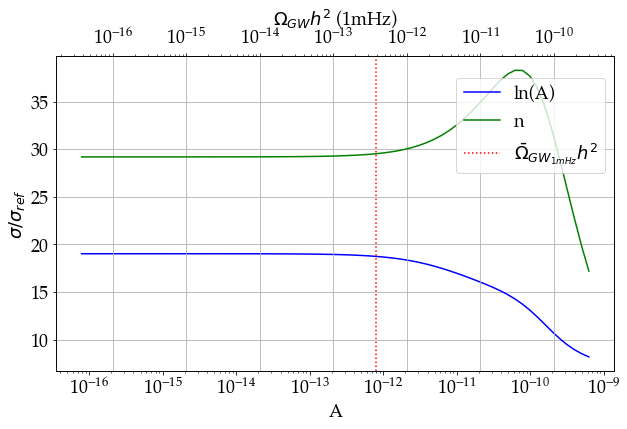

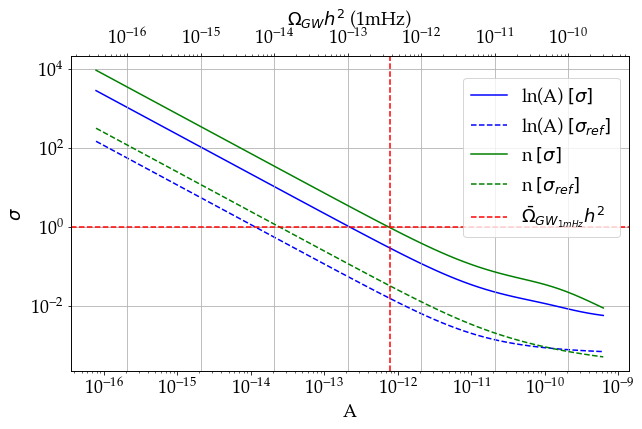

In [222]:
  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(7.87*10**log_pl_amp,ratio_res_array_varyGWB_CSD_pl[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_pl_1mHz,ratio_res_array_varyGWB_CSD_pl[:,1],'g-', label='n')
#plt.axvline(x=Omega_ref,c='r',ls='--', label='$\Omega$_ref_C')
ax2.axvline(x=Omega_ref_pl,c='r',ls=':', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########



fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.loglog(7.87*10**log_pl_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_pl[:,0]),'b-', label='ln(A) $[\sigma]$')
ax1.loglog(7.87*10**log_pl_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl[:,0]),'b--', label='ln(A) $[\sigma_{ref}]$ ')
ax2 = ax1.twiny()
ax2.loglog(Omega_pl_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_pl[:,1]),'g-', label='n $[\sigma]$')
ax2.loglog(Omega_pl_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl[:,1]),'g--', label='n $[\sigma_{ref}]$')
ax1.set_ylabel('$\sigma$')
ax1.set_xlabel('A')
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)')

ax2.axvline(x=Omega_ref_pl,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')

plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)

## Power law with GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

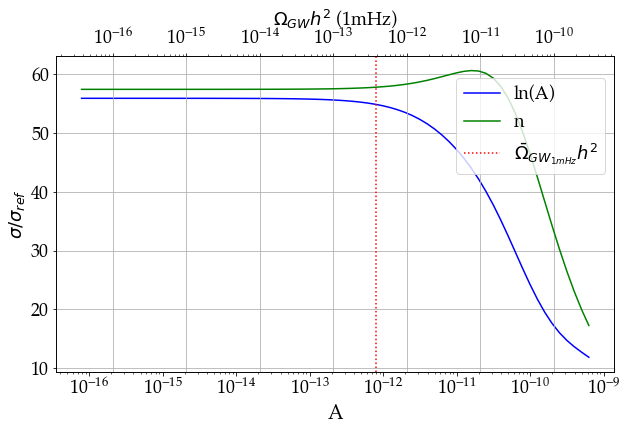

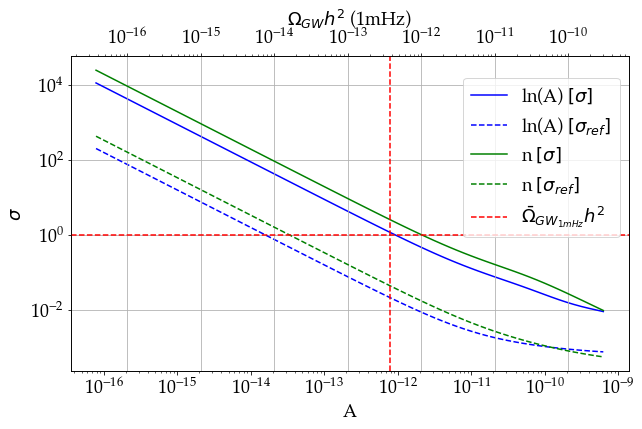

In [223]:
  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########
    
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(7.87*10**log_pl_amp,ratio_res_array_varyGWB_CSD_pl_GB[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_pl_1mHz,ratio_res_array_varyGWB_CSD_pl_GB[:,1],'g-', label='n')
#plt.axvline(x=Omega_ref,c='r',ls='--', label='$\Omega$_ref_C')
ax2.axvline(x=Omega_ref_pl,c='r',ls=':', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=20)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########



fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.loglog(7.87*10**log_pl_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_GB[:,0]),'b-', label='ln(A) $[\sigma]$')
ax1.loglog(7.87*10**log_pl_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_GB[:,0]),'b--', label='ln(A) $[\sigma_{ref}]$ ')
ax2 = ax1.twiny()
ax2.loglog(Omega_pl_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_GB[:,1]),'g-', label='n $[\sigma]$')
ax2.loglog(Omega_pl_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_GB[:,1]),'g--', label='n $[\sigma_{ref}]$')
ax1.set_ylabel('$\sigma$')
ax1.set_xlabel('A')
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)')

ax2.axvline(x=Omega_ref_pl,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')

plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


## Gaussian bump  without GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

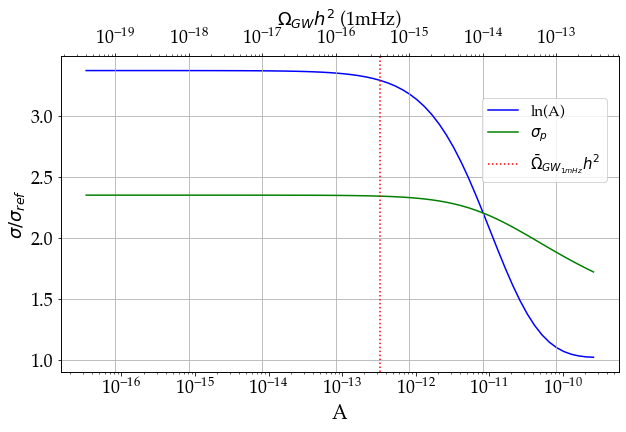

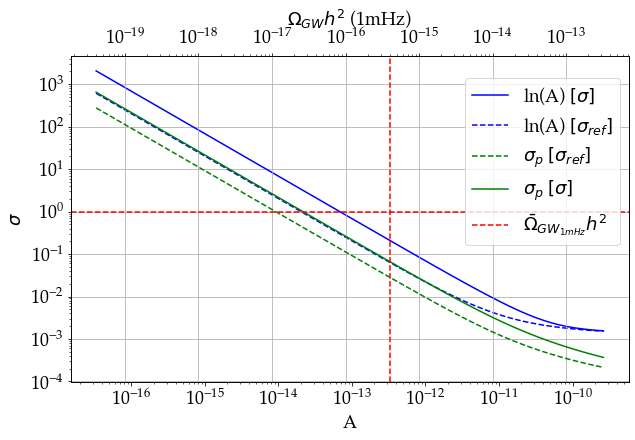

In [119]:
  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_gaussian_amp,ratio_res_array_varyGWB_CSD_gaussian[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_gaussian_1mHz,ratio_res_array_varyGWB_CSD_gaussian[:,1],'g-', label='$\sigma_p$ ')
#plt.axvline(x=Omega_ref,c='r',ls='--', label='$\Omega$_ref_C')
ax2.axvline(x=Omega_ref_gaussian,c='r',ls=':', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=20)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper left', bbox_to_anchor=(0.7, 0.8))



  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########
    
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.loglog(10**log_gaussian_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_gaussian[:,0]),'b-', label='ln(A) $[\sigma]$')
ax1.loglog(10**log_gaussian_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_gaussian[:,0]),'b--', label='ln(A) $[\sigma_{ref}]$')
ax2 = ax1.twiny()
ax2.loglog(Omega_gaussian_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_gaussian[:,1]),'g--', label='$\sigma_p$ $[\sigma_{ref}]$ ')
ax2.loglog(Omega_gaussian_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_gaussian[:,1]),'g-', label='$\sigma_p$ $[\sigma]$ ')
ax2.axvline(x=Omega_ref_gaussian,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')

ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


## Gaussian bump with GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

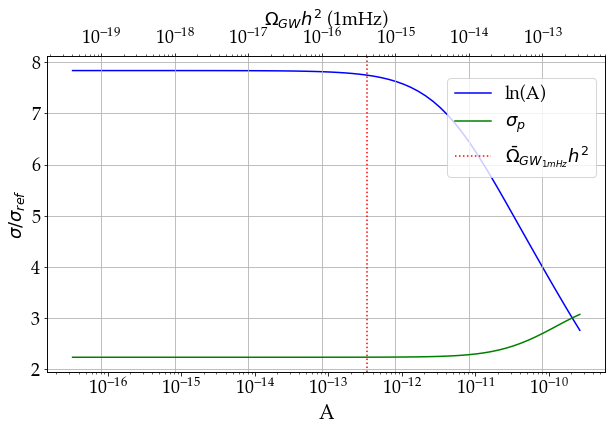

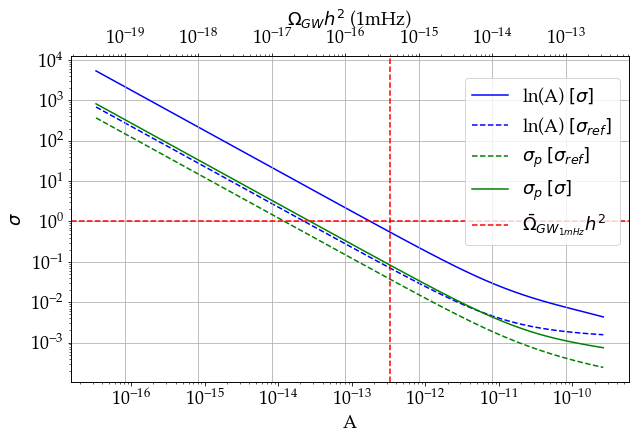

In [120]:
  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_gaussian_amp,ratio_res_array_varyGWB_CSD_gaussian_GB[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_gaussian_1mHz,ratio_res_array_varyGWB_CSD_gaussian_GB[:,1],'g-', label='$\sigma_p$ ')
#plt.axvline(x=Omega_ref,c='r',ls='--', label='$\Omega$_ref_C')
ax2.axvline(x=Omega_ref_gaussian,c='r',ls=':', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########
    
    
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.loglog(10**log_gaussian_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_gaussian_GB[:,0]),'b-', label='ln(A) $[\sigma]$')
ax1.loglog(10**log_gaussian_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_gaussian_GB[:,0]),'b--', label='ln(A) $[\sigma_{ref}]$')
ax2 = ax1.twiny()
ax2.loglog(Omega_gaussian_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_gaussian_GB[:,1]),'g--', label='$\sigma_p$ $[\sigma_{ref}]$ ')
ax2.loglog(Omega_gaussian_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_gaussian_GB[:,1]),'g-', label='$\sigma_p$ $[\sigma]$ ')
ax2.axvline(x=Omega_ref_gaussian,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')

ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)



 ## First order phase transition without GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

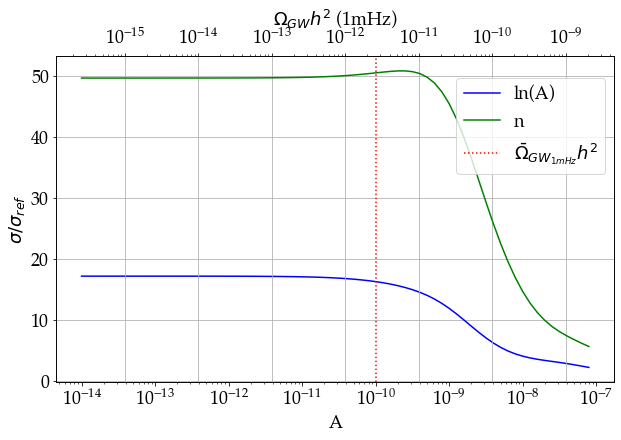

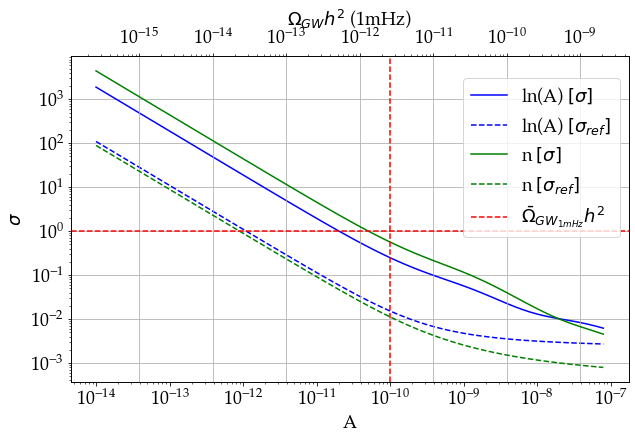

In [121]:
  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_FOPT_amp,ratio_res_array_varyGWB_CSD_FOPT[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_FOPT_1mHz,ratio_res_array_varyGWB_CSD_FOPT[:,1],'g-', label='n ')
ax2.axvline(x=Omega_ref_FOPT,c='r',ls=':', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)



  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########
    
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.loglog(10**log_FOPT_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_FOPT[:,0]),'b-', label='ln(A) $[\sigma]$ ')
ax1.loglog(10**log_FOPT_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_FOPT[:,0]),'b--', label='ln(A) $[\sigma_{ref}]$ ')
ax2 = ax1.twiny()
ax2.loglog(Omega_FOPT_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_FOPT[:,1]),'g-', label='n $[\sigma]$')
ax2.loglog(Omega_FOPT_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_FOPT[:,1]),'g--', label='n $[\sigma_{ref}]$')
ax2.axvline(x=Omega_ref_FOPT,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')


ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


# First order phase transition with GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

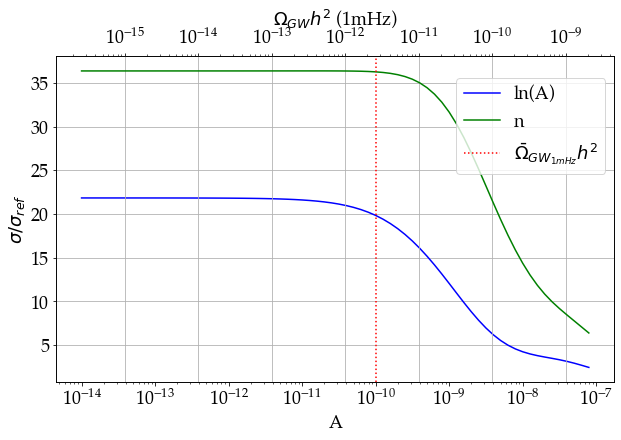

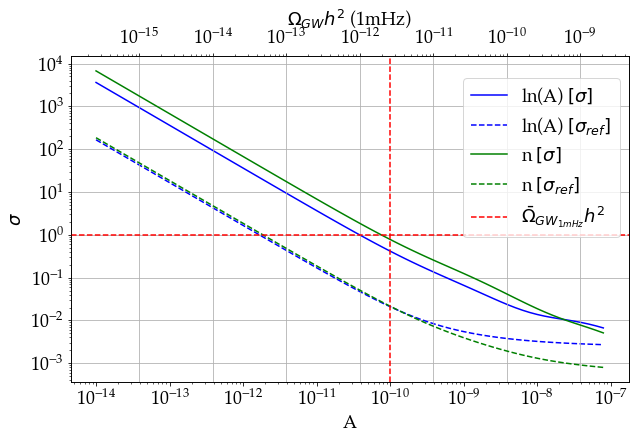

In [122]:

  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########
    
    
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_FOPT_amp,ratio_res_array_varyGWB_CSD_FOPT_GB[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_FOPT_1mHz,ratio_res_array_varyGWB_CSD_FOPT_GB[:,1],'g-', label='n ')
ax2.axvline(x=Omega_ref_FOPT,c='r',ls=':', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.loglog(10**log_FOPT_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_FOPT_GB[:,0]),'b-', label='ln(A) $[\sigma]$ ')
ax1.loglog(10**log_FOPT_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_FOPT_GB[:,0]),'b--', label='ln(A) $[\sigma_{ref}]$ ')
ax2 = ax1.twiny()
ax2.loglog(Omega_FOPT_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_FOPT_GB[:,1]),'g-', label='n $[\sigma]$')
ax2.loglog(Omega_FOPT_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_FOPT_GB[:,1]),'g--', label='n $[\sigma_{ref}]$')
ax2.axvline(x=Omega_ref_FOPT,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')


ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)



## Power low with running without GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

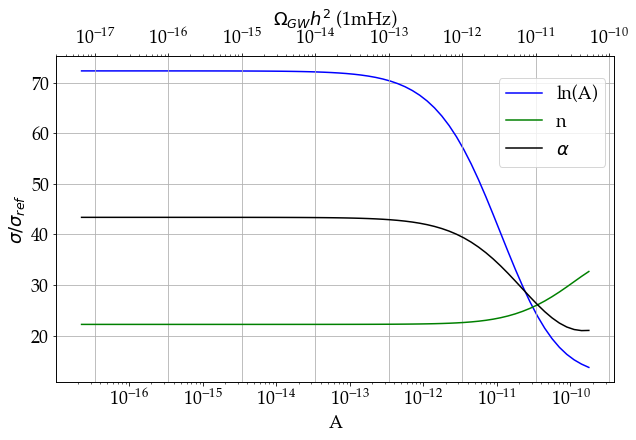

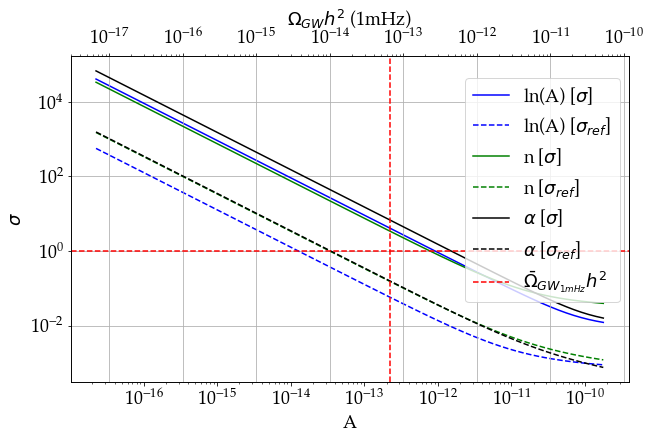

In [125]:

  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_pl_wr_amp,ratio_res_array_varyGWB_CSD_pl_wr[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_pl_wr_1mHz,ratio_res_array_varyGWB_CSD_pl_wr[:,1],'g-', label='n ')
ax2.semilogx(Omega_pl_wr_1mHz,ratio_res_array_varyGWB_CSD_pl_wr[:,2],'k-', label='$\\alpha$')
#plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_pl_wr_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr[:,0]),'b-', label='ln(A) [$\sigma$] ')
ax1.semilogx(10**log_pl_wr_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_wr[:,0]),'b--', label='ln(A) [$\sigma_{ref}$] ')
ax2 = ax1.twiny()
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr[:,1]),'g-', label='n [$\sigma$]')
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_wr[:,1]),'g--', label='n [$\sigma_{ref}$]')
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr[:,2]),'k-', label='$\\alpha$ [$\sigma$]')
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_wr[:,2]),'k--', label='$\\alpha$ [$\sigma_{ref}$]')
ax2.axvline(x=Omega_ref_pl_wr,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')

ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)



# Power law-with-running with GB

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

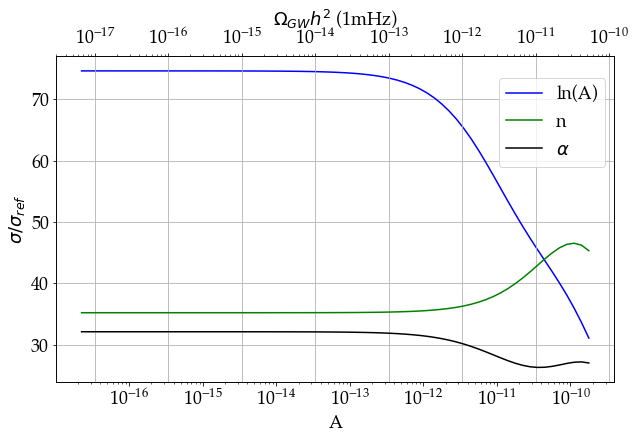

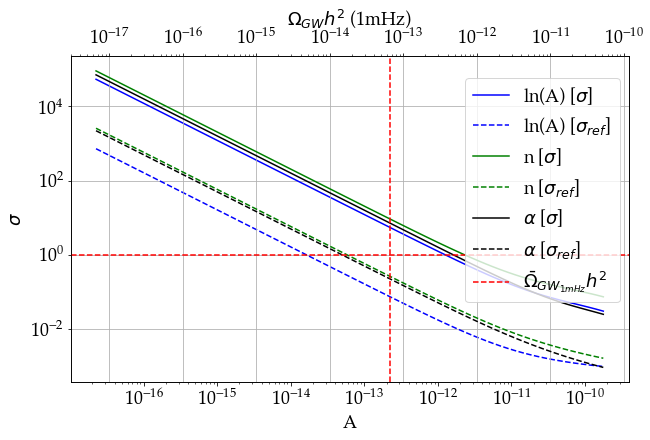

In [127]:

  ####. --------- PrecisionRatio_Vs_Omega_Vs_amplitude   #########


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_pl_wr_amp,ratio_res_array_varyGWB_CSD_pl_wr_GB[:,0],'b-', label='ln(A)')
ax2 = ax1.twiny()
ax2.semilogx(Omega_pl_wr_1mHz,ratio_res_array_varyGWB_CSD_pl_wr_GB[:,1],'g-', label='n ')
ax2.semilogx(Omega_pl_wr_1mHz,ratio_res_array_varyGWB_CSD_pl_wr_GB[:,2],'k-', label='$\\alpha$')
#plt.subplots_adjust(bottom=0.15)
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma/\sigma_{ref}$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
#ax1.grid(True)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


  ####. --------- Precision_Vs_Omega_Vs_amplitude   #########


fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.semilogx(10**log_pl_wr_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr_GB[:,0]),'b-', label='ln(A) [$\sigma$] ')
ax1.semilogx(10**log_pl_wr_amp,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_wr_GB[:,0]),'b--', label='ln(A) [$\sigma_{ref}$] ')
ax2 = ax1.twiny()
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr_GB[:,1]),'g-', label='n [$\sigma$]')
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_wr_GB[:,1]),'g--', label='n [$\sigma_{ref}$]')
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr_GB[:,2]),'k-', label='$\\alpha$ [$\sigma$]')
ax2.loglog(Omega_pl_wr_1mHz,np.sqrt(ref_prec_res_array_varyGWB_CSD_pl_wr_GB[:,2]),'k--', label='$\\alpha$ [$\sigma_{ref}$]')
ax2.axvline(x=Omega_ref_pl_wr,c='r',ls='--', label='$\\bar{\Omega}_{{GW}_{1mHz}} h^2$')
ax2.axhline(y=1,c='r',ls='--')
ax2.set_xlabel('$\Omega_{GW} h^2$ (1mHz)',fontsize=18)
ax1.set_xlabel('A', fontsize=18)
ax1.set_ylabel('$\sigma$', fontsize=18)
plt.ylim()
#ax1.set_xlim(1e-16, 2e-10)
#ax2.set_xlim(1e-16, 2e-10)
ax1.yaxis.grid(True, linestyle='-', alpha=1)
ax2.xaxis.grid(True, linestyle='-', alpha=1)
ax1.tick_params(axis='both', which='major', labelsize=18)  # For ax1
ax2.tick_params(axis='both', which='major', labelsize=18)  # For ax2
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.85),fontsize=18)


# Plotting the SNR without or with GB vs error of the log(A)

/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/murmar/opt/an

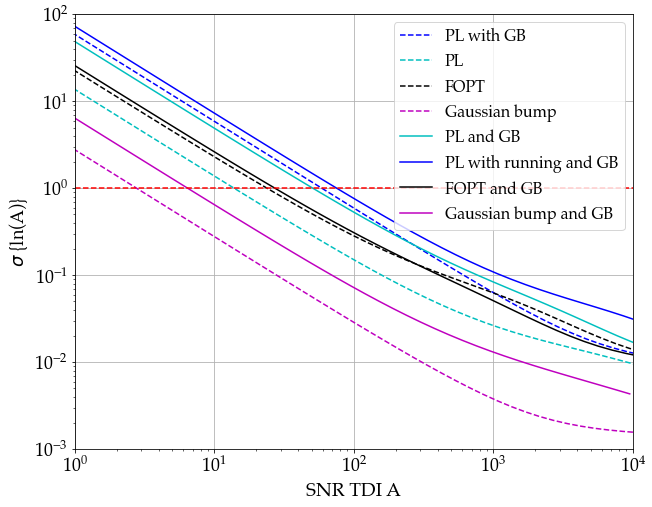

In [164]:
plt.figure(figsize=(15, 10))

plt.loglog(SNRA_pl_wr_amp, np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr[:,0]),'b--' , label='Power law with running',linewidth=2)
plt.loglog(SNRA_pl_amp,np.sqrt(full_prec_res_array_varyGWB_CSD_pl[:,0]),'c--' ,label='Power law',linewidth=2)
plt.loglog(SNRA_FOPT_amp, np.sqrt(full_prec_res_array_varyGWB_CSD_FOPT[:,0]),'k--' , label='FOPT',linewidth=2)
plt.loglog(SNRA_Gau_amp, np.sqrt(full_prec_res_array_varyGWB_CSD_gaussian[:,0]),'m--', label='Gaussian bump',linewidth=2)


plt.loglog(SNRA_pl_GB_amp, np.sqrt(full_prec_res_array_varyGWB_CSD_pl_GB[:,0]),'c-' , label='Power law and GB',linewidth=2)
plt.loglog(SNRA_pl_wr_GB_amp, np.sqrt(full_prec_res_array_varyGWB_CSD_pl_wr_GB[:,0]),'b-' ,label='Power law with running and GB',linewidth=2)
plt.loglog(SNRA_FOPT_GB_amp, np.sqrt(full_prec_res_array_varyGWB_CSD_FOPT_GB[:,0]),'k-',label='FOPT and GB',linewidth=2)
plt.loglog(SNRA_Gau_GB_amp, np.sqrt(full_prec_res_array_varyGWB_CSD_gaussian_GB[:,0]),'m-'  , label='Gaussian bump and GB',linewidth=2)

plt.axhline(y=1,c='r',ls='--',linewidth=2)
# set the x and y axis labels
plt.xlabel('SNR A', fontsize=28)
plt.ylabel('$\sigma$  [ln(A)]', fontsize=28)

plt.xlim(1, 1e4)
plt.ylim(1e-3, 1e3)


# add a grid to the plot
plt.grid(True)

# display the legend
plt.legend(fontsize=24,loc="upper right",ncol=2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
# show the plot



plt.show()

# Plotting the SNR without or with GB vs energy density at 1mHz

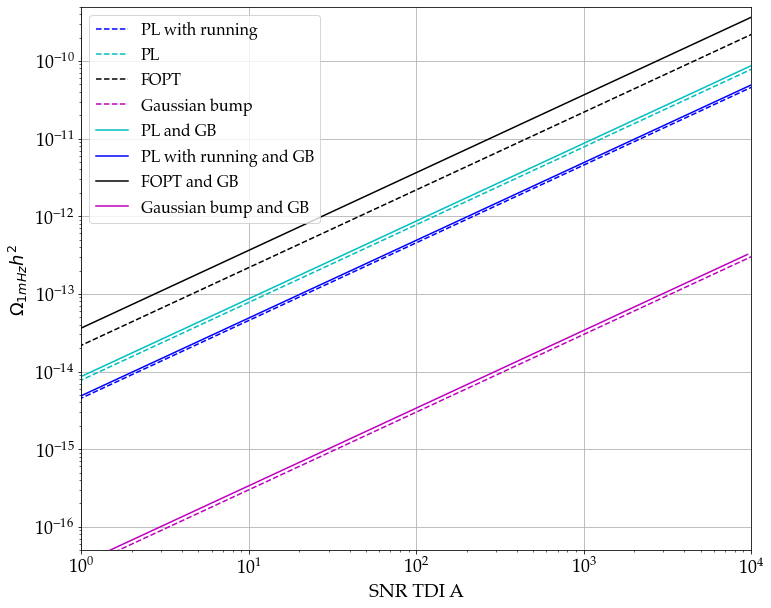

In [163]:
plt.figure(figsize=(15, 12))

plt.loglog(SNRA_pl_wr_amp, Omega_pl_wr_1mHz,'b--' , label='Power law with running',linewidth=2)
plt.loglog(SNRA_pl_amp, Omega_pl_1mHz,'c--' ,label='Power law',linewidth=2)
plt.loglog(SNRA_FOPT_amp, Omega_FOPT_1mHz,'k--' , label='FOPT',linewidth=2)
plt.loglog(SNRA_Gau_amp, Omega_gaussian_1mHz,'m--' , label='Gaussian bump',linewidth=2)


plt.loglog(SNRA_pl_GB_amp, Omega_pl_1mHz,'c-' , label='Power law and GB',linewidth=2)
plt.loglog(SNRA_pl_wr_GB_amp,  Omega_pl_wr_1mHz,'b-' ,label='Power law with running and GB',linewidth=2)
plt.loglog(SNRA_FOPT_GB_amp,  Omega_FOPT_1mHz,'k-' ,label='FOPT and GB',linewidth=2)
plt.loglog(SNRA_Gau_GB_amp, Omega_gaussian_1mHz,'m-' , label='Gaussian bump and GB',linewidth=2)

#plt.axhline(y=1,c='r',ls='--')
# set the x and y axis labels
plt.xlabel('SNR TDI A', fontsize=28)
plt.ylabel('$\Omega_{1mHz} h^2$ ' ,fontsize=28)

plt.xlim(1, 1e4)
#plt.ylim(1e-17,5* 1e-10)
plt.ylim(2e-18, 1e-10)
    
plt.grid()
plt.legend(fontsize=24,loc="lower right",ncol=2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()



# show the plot



plt.show()

# Now we vary the prior from very small to very big to understand the impact on parameter estimation and see if we can put any significance requirement on the noise knowledge

## printing the value of the snr: I choice and SNR of b/w 120 - 140 for all of them without GB

In [224]:
print(SNRA_pl_wr_amp[ 50], 10**log_pl_wr_amp[50])
print(SNRA_pl_amp[ 45], 6.98*10**log_pl_amp[45])
print(SNRA_FOPT_amp[ 41], 10**log_FOPT_amp[41])
print(SNRA_Gau_amp[ 50], 10**log_gaussian_amp[50])

[0.] 2.238721138568713e-12
[153.99301528] 2.207269806797854e-12
[0.] 1.258925411794125e-10
[0.] 3.3113112148264494e-12


## printing the value of the snr: I choice and SNR of about 120 - 140 for all of them with GB

In [225]:
print(SNRA_pl_wr_GB_amp[ 50], 10**log_pl_wr_amp[50])
print(SNRA_pl_GB_amp[ 45], 7.87*10**log_pl_amp[45])
print(SNRA_FOPT_GB_amp[ 43], 10**log_FOPT_amp[43])
print(SNRA_Gau_GB_amp[ 50], 10**log_gaussian_amp[50])

[0.] 2.238721138568713e-12
[138.20959917] 2.4887125185528812e-12
[0.] 1.9952623149688094e-10
[0.] 3.3113112148264494e-12


## choosing the reference log amplitude for the difference models

In [226]:
### ----- power law ####

log_pl_amp_ref =  log_pl_amp[45]
log_pl_amp_ref2 = -13

### ----- power law with running ####

log_pl_wr_amp_ref =  log_pl_wr_amp[50]

### ----- gaussian bump  ####
log_gaussian_amp_ref = log_gaussian_amp[50]

log_gaussian_amp_ref2 = A_gaussian

log_FOPT_amp_ref  =   log_FOPT_amp[43]


# In this case we can precompute the total PSD and both the instrumental derivatives and the 
# background derivatives. The only thing we will vary is the prior we add before inverting the Fisher matrix.

In [227]:



############### power law ref value #####
GWB_par_pl_ref2=[np.log(7.87*B*10**log_pl_amp_ref2),n_pl] 
powerlaw_CSD_ref2,powerlaw_Derivs_ref_CSD2 = BackGrounds_unq.SGWB_powerlaw_Derivs(GWB_par_pl_ref2)


powerlaw_CSD_ref_Tot2=InstAEzeta1_CSD+powerlaw_CSD_ref2
powerlaw_CSD_ref_Inv2=MakePSDInv(powerlaw_CSD_ref_Tot2,Nch)


powerlaw_CSD_ref2_Tot_GB=InstAEzeta1_CSD+powerlaw_CSD_ref2 +GB_CSD
powerlaw_CSD_ref2_Inv_GB=MakePSDInv(powerlaw_CSD_ref2_Tot_GB,Nch)
############### power law GB value



###############


############### power law
GWB_par_pl_ref=[np.log(7.87*B*10**log_pl_amp_ref),n_pl] 
powerlaw_CSD_ref,powerlaw_Derivs_ref_CSD = BackGrounds_unq.SGWB_powerlaw_Derivs(GWB_par_pl_ref)


powerlaw_CSD_ref_Tot=InstAEzeta1_CSD+powerlaw_CSD_ref
powerlaw_CSD_ref_Inv=MakePSDInv(powerlaw_CSD_ref_Tot,Nch)

#######
powerlaw_CSD_ref_GB_Tot=InstAEzeta1_CSD+powerlaw_CSD_ref+GB_CSD
powerlaw_CSD_ref_Inv_GB=MakePSDInv(powerlaw_CSD_ref_GB_Tot,Nch)

###############


############### power law with running 
GWB_par_pl_wr_ref=[np.log(B*10**log_pl_wr_amp_ref),n_pl_wr,alpha_pl_wr] 
powerlaw_wr_CSD_ref,powerlaw_wr_Derivs_ref_CSD = BackGrounds_unq.SGWB_Powerlaw_with_running_Derivs(GWB_par_pl_wr_ref)

powerlaw_wr_CSD_ref_Tot=InstAEzeta1_CSD+powerlaw_wr_CSD_ref
powerlaw_wr_CSD_ref_Inv=MakePSDInv(powerlaw_wr_CSD_ref_Tot,Nch)
################

############### power law with running GB

powerlaw_wr_CSD_ref_GB_Tot=InstAEzeta1_CSD+powerlaw_wr_CSD_ref+GB_CSD
powerlaw_wr_CSD_ref_Inv_GB=MakePSDInv(powerlaw_wr_CSD_ref_GB_Tot,Nch)




################ gaussian bump
GWB_par_gaussian_ref=[np.log(B*10**log_gaussian_amp_ref),sigma ] 
gaussian_CSD_ref,gaussian_Derivs_ref_CSD = BackGrounds_unq.SGWB_gaussian_bump_Derivs(GWB_par_gaussian_ref)

gaussian_CSD_ref_Tot=InstAEzeta1_CSD+gaussian_CSD_ref
gaussian_CSD_ref_Inv=MakePSDInv(gaussian_CSD_ref_Tot,Nch)
################

################ gaussian bump with GB

gaussian_CSD_ref_GB_Tot=InstAEzeta1_CSD+gaussian_CSD_ref+GB_CSD
gaussian_CSD_ref_Inv_GB=MakePSDInv(gaussian_CSD_ref_GB_Tot,Nch)

################ gaussian bump2
GWB_par_gaussian_ref2=[np.log(B*10**log_gaussian_amp_ref2),sigma ] 
gaussian_CSD_ref2,gaussian_Derivs_ref_CSD2 = BackGrounds_unq.SGWB_gaussian_bump_Derivs(GWB_par_gaussian_ref2)

gaussian_CSD_ref_Tot2=InstAEzeta1_CSD+gaussian_CSD_ref2
gaussian_CSD_ref_Inv2=MakePSDInv(gaussian_CSD_ref_Tot2,Nch)
################




################ FOPT
GWB_par_FOPT_ref=[np.log(B*10**log_FOPT_amp_ref ),n_FOPT ] 
FOPT_CSD_ref,FOPT_Derivs_ref_CSD = BackGrounds_unq.SGWB_FOPT_Derivs(GWB_par_FOPT_ref)

FOPT_CSD_ref_Tot=InstAEzeta1_CSD+FOPT_CSD_ref
FOPT_CSD_ref_Inv=MakePSDInv(FOPT_CSD_ref_Tot,Nch)

################ FOPT with GB

FOPT_CSD_ref_GB_Tot=InstAEzeta1_CSD+FOPT_CSD_ref+GB_CSD
FOPT_CSD_ref_Inv_GB=MakePSDInv(FOPT_CSD_ref_GB_Tot,Nch)
##################




## Defining values to be used for instrumental noise uncertainties and create arrays to store the results.

In [228]:
Spline_Uncert=np.arange(-10.0,6.0,0.2)
Ninst_CSD=np.shape(InstAEzeta1_CSD_Derivs)[0]
PSDsigs_oneChan=np.zeros(len(logf_knots))

## Power low

In [229]:
##### ---------- ######

ratio_res_array_varySig_pl=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
full_prec_res_array_varySig_pl=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
ref_prec_res_array_varySig_pl=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
prior_inv_CSD_pl=np.zeros((Nsrc_pl+Ninst_CSD,Nsrc_pl+Ninst_CSD))



ratio_res_array_varySig_pl_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
full_prec_res_array_varySig_pl_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
ref_prec_res_array_varySig_pl_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
prior_inv_CSD_pl_GB=np.zeros((Nsrc_pl+Ninst_CSD+1,Nsrc_pl+Ninst_CSD+1))


##### ---------- ######

ratio_res_array_varySig_pl2=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
full_prec_res_array_varySig_pl2=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
ref_prec_res_array_varySig_pl2=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))

ratio_res_array_varySig_pl2_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
full_prec_res_array_varySig_pl2_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))
ref_prec_res_array_varySig_pl2_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl))

##### ---------- ######



# Loop over values for the uncertainty. Note the only thing that we are changing is "refsig" from 
# the previous example. This corresponds to assuming that the uncertaities at all frequencies in
# all of the PSDs is the same.


# construct prior inv

@njit
def get_prior_inv(prior_inv_CSD_pl,prior_inv_CSD_pl_GB, PSDsigs_oneChan, Nsrc_pl, Nch):
    for i in range(Nch*Nch):
        for k in range(len(PSDsigs_oneChan)):
            # one over sigma =   1/PSDsigs_oneChan
            prior_inv_CSD_pl[Nsrc_pl+i*len(PSDsigs_oneChan)+k,Nsrc_pl+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            prior_inv_CSD_pl_GB[Nsrc_pl+1+i*len(PSDsigs_oneChan)+k,Nsrc_pl+1+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            
for j in range(len(Spline_Uncert)):
    print("completed", j/len(Spline_Uncert) )
    # refsig = e^(log(10) * Uncer) = e^( log (10^(Uncer)) ) = 10^(Uncer) = 10^(Spline_Uncert=np.arange(-10.0,6.0,0.2))
    refsig=np.exp(np.log(10.0)*Spline_Uncert[j]) # prior uncertainty value 
    PSDsigs_oneChan = np.asarray([refsig for i in range(len(PSDsigs_oneChan))])
    # get prior inv
    get_prior_inv(prior_inv_CSD_pl,prior_inv_CSD_pl_GB, PSDsigs_oneChan, Nsrc_pl, Nch)
    
    
    
    FM_pl_ref,FM_pl_full_ref,fish_pl_inv_ref,fish_pl_full_inv_ref,ratiores_pl_ref=JointFisherMatrix(powerlaw_Derivs_ref_CSD,InstAEzeta1_CSD_Derivs, powerlaw_CSD_ref_Inv,prior_inv_CSD_pl,Nch)
    ratio_res_array_varySig_pl[j]=ratiores_pl_ref
    full_prec_res_array_varySig_pl[j]=np.diag(np.array(fish_pl_full_inv_ref.tolist()))[:Nsrc_pl]
    ref_prec_res_array_varySig_pl[j]=np.diag(np.array(fish_pl_inv_ref.tolist()))[:Nsrc_pl]
    ###########################
    
    FM_pl_ref2,FM_pl_full_ref2,fish_pl_inv_ref2,fish_pl_full_inv_ref2,ratiores_pl_ref2=JointFisherMatrix(powerlaw_Derivs_ref_CSD2,InstAEzeta1_CSD_Derivs, powerlaw_CSD_ref_Inv2,prior_inv_CSD_pl,Nch)
    ratio_res_array_varySig_pl2[j]=ratiores_pl_ref2
    full_prec_res_array_varySig_pl2[j]=np.diag(np.array(fish_pl_full_inv_ref2.tolist()))[:Nsrc_pl]
    ref_prec_res_array_varySig_pl2[j]=np.diag(np.array(fish_pl_inv_ref2.tolist()))[:Nsrc_pl]
    
    #############################################
    
    FM_pl_ref_GB,FM_pl_full_ref_GB,fish_pl_inv_ref_GB,fish_pl_full_inv_ref_GB,ratiores_pl_ref_GB=JointFisherMatrix(powerlaw_Derivs_ref_CSD,GB_CSD_noise_derivs, powerlaw_CSD_ref_Inv_GB,prior_inv_CSD_pl_GB,Nch)
    ratio_res_array_varySig_pl_GB[j]=ratiores_pl_ref_GB
    full_prec_res_array_varySig_pl_GB[j]=np.diag(np.array(fish_pl_full_inv_ref_GB.tolist()))[:Nsrc_pl]
    ref_prec_res_array_varySig_pl_GB[j]=np.diag(np.array(fish_pl_inv_ref_GB.tolist()))[:Nsrc_pl]
    
    
        #### with GB
    
    FM_pl_ref2_GB,FM_pl_full_ref2_GB,fish_pl_inv_ref2_GB,fish_pl_full_inv_ref2_GB,ratiores_pl_ref2_GB=JointFisherMatrix(powerlaw_Derivs_ref_CSD2,GB_CSD_noise_derivs, powerlaw_CSD_ref2_Inv_GB,prior_inv_CSD_pl_GB,Nch)
    ratio_res_array_varySig_pl2_GB[j]=ratiores_pl_ref2_GB
    full_prec_res_array_varySig_pl2_GB[j]=np.diag(np.array(fish_pl_full_inv_ref2_GB.tolist()))[:Nsrc_pl]
    ref_prec_res_array_varySig_pl2_GB[j]=np.diag(np.array(fish_pl_inv_ref2_GB.tolist()))[:Nsrc_pl]


completed 0.0


/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/1474278378.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_pl[j]=ratiores_pl_ref
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/1474278378.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  full_prec_res_array_varySig_pl[j]=np.diag(np.array(fish_pl_full_inv_ref.tolist()))[:Nsrc_pl]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/1474278378.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  ref_prec_res_array_varySig_pl[j]=np.diag(np.array(fish_pl_inv_ref.tolist()))[:Nsrc_pl]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/1474278378.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_pl2[j]=ratiores_pl_ref2
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_13491/1474278378.py:55: Com

completed 0.0125
completed 0.025
completed 0.0375
completed 0.05
completed 0.0625
completed 0.075
completed 0.0875
completed 0.1
completed 0.1125
completed 0.125
completed 0.1375
completed 0.15
completed 0.1625
completed 0.175
completed 0.1875
completed 0.2
completed 0.2125
completed 0.225
completed 0.2375
completed 0.25
completed 0.2625
completed 0.275
completed 0.2875
completed 0.3
completed 0.3125
completed 0.325
completed 0.3375
completed 0.35
completed 0.3625
completed 0.375
completed 0.3875
completed 0.4
completed 0.4125
completed 0.425
completed 0.4375
completed 0.45
completed 0.4625
completed 0.475
completed 0.4875
completed 0.5
completed 0.5125
completed 0.525
completed 0.5375
completed 0.55
completed 0.5625
completed 0.575
completed 0.5875
completed 0.6
completed 0.6125
completed 0.625
completed 0.6375
completed 0.65
completed 0.6625
completed 0.675
completed 0.6875
completed 0.7
completed 0.7125
completed 0.725
completed 0.7375
completed 0.75
completed 0.7625
completed 0.775

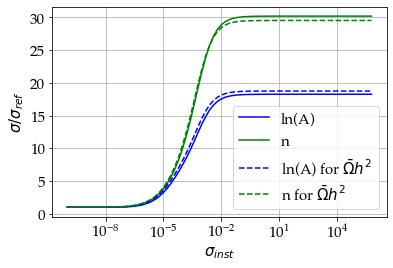

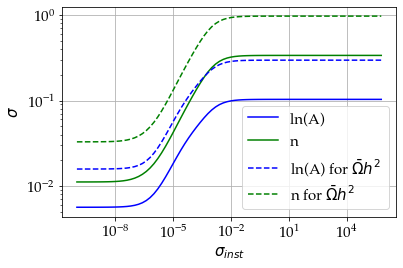

In [230]:

##### Now we plot the results. Again we make two figures, showing respectively the ratio of uncertainties 
##### and the full uncertainty as a function of the magnitude of the allowed prior uncertainty in the
##### instrumental noise.

#### without Galactic binaries

#### ratio of uncertainties #######
plt.figure('Power law correlated ratio')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl[:,1],'g-', label='n')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl2[:,0],'b--', label='ln(A) for $\\bar{\Omega} h^2$ ')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl2[:,1],'g--', label='n for $\\bar{\Omega} h^2$ ')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
#plt.xlim(1e-10, 1e5)
plt.legend()
plt.grid(True)

#### full uncertainties #######

plt.figure('Power law correlated')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl[:,0]),'b-', label='ln(A) ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl[:,1]),'g-', label='n  ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl2[:,0]),'b--', label='ln(A) for $\\bar{\Omega} h^2$ ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl2[:,1]),'g--', label='n for $\\bar{\Omega} h^2$ ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_pl[:,0],'b--', label='ln(A)  $[\sigma_{ref}]$ ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_pl[:,1],'g--', label='n  $[\sigma_{ref}]$')
#plt.xlim(1e-9, 1e4)
#plt.ylim(1e-15, 1e-8)

plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid(True)


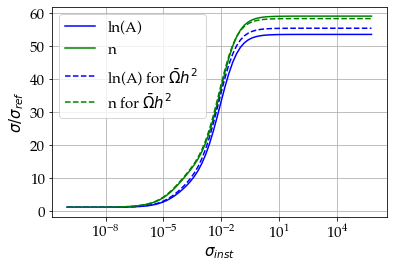

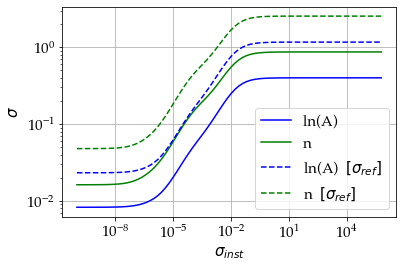

In [231]:
#### wit Galactic binaries


#### ratio of uncertainties #######

plt.figure('Power law correlated ratio GB')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_GB[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_GB[:,1],'g-', label='n')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl2_GB[:,0],'b--', label='ln(A) for $\\bar{\Omega} h^2$ ')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl2_GB[:,1],'g--', label='n for $\\bar{\Omega} h^2$ ')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
#plt.xlim(1e-10, 1e5)
plt.legend()
plt.grid(True)



#### fulll uncertainties #######

plt.figure('Power law correlated GB')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_GB[:,0]),'b-', label='ln(A) ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_GB[:,1]),'g-', label='n  ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl2_GB[:,0]),'b--', label='ln(A)  $[\sigma_{ref}]$ ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl2_GB[:,1]),'g--', label='n  $[\sigma_{ref}]$')
#plt.xlim(1e-9, 1e4)
#plt.ylim(1e-15, 1e-8)

plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
plt.legend()
plt.grid(True)


### First order phase transition

In [380]:
#  --------------- #

ratio_res_array_varySig_FOPT=np.zeros(shape=(len(Spline_Uncert),Nsrc_FOPT))
full_prec_res_array_varySig_FOPT=np.zeros(shape=(len(Spline_Uncert),Nsrc_FOPT))
ref_prec_res_array_varySig_FOPT=np.zeros(shape=(len(Spline_Uncert),Nsrc_FOPT))
prior_inv_CSD_FOPT=np.zeros((Nsrc_FOPT+Ninst_CSD,Nsrc_FOPT+Ninst_CSD))

#  --------------- #

ratio_res_array_varySig_FOPT_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_FOPT))
full_prec_res_array_varySig_FOPT_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_FOPT))
ref_prec_res_array_varySig_FOPT_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_FOPT))
prior_inv_CSD_FOPT_GB=np.zeros((Nsrc_FOPT+1+Ninst_CSD,Nsrc_FOPT+1+Ninst_CSD))


# Loop over values for the uncertainty. Note the only thing that we are changing is "refsig" from 
# the previous example. This corresponds to assuming that the uncertaities at all frequencies in
# all of the PSDs is the same.


# construct prior inv

@njit
def get_prior_inv(prior_inv_CSD_FOPT,prior_inv_CSD_FOPT_GB, PSDsigs_oneChan, Nsrc_FOPT, Nch):
    for i in range(np.int(Nch*(Nch+1)/2)):
        for k in range(len(PSDsigs_oneChan)):
            # one over sigma =   1/PSDsigs_oneChan
            prior_inv_CSD_FOPT[Nsrc_FOPT+i*len(PSDsigs_oneChan)+k,Nsrc_FOPT+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            prior_inv_CSD_FOPT_GB[Nsrc_FOPT+1+i*len(PSDsigs_oneChan)+k,Nsrc_FOPT+1+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            
for j in range(len(Spline_Uncert)):
    print("completed", j/len(Spline_Uncert) )
    # refsig = e^(log(10) * Uncer) = e^( log (10^(Uncer)) ) = 10^(Uncer) = 10^(Spline_Uncert=np.arange(-10.0,6.0,0.2))
    refsig=np.exp(np.log(10.0)*Spline_Uncert[j]) # prior uncertainty value 
    PSDsigs_oneChan = np.asarray([refsig for i in range(len(PSDsigs_oneChan))])
    # get prior in
    get_prior_inv(prior_inv_CSD_FOPT,prior_inv_CSD_FOPT_GB, PSDsigs_oneChan, Nsrc_FOPT, Nch)
    
     ###########################
    
    FM_FOPT_ref,FM_FOPT_full,fish_FOPT_ref_inv,fish_FOPT_full_inv,ratiores_FOPT=JointFisherMatrix(FOPT_Derivs_ref_CSD,InstAEzeta1_CSD_Derivs,FOPT_CSD_ref_Inv,prior_inv_CSD_FOPT,Nch)
  
    ratio_res_array_varySig_FOPT[j]=ratiores_FOPT
    full_prec_res_array_varySig_FOPT[j]=np.diag(np.array(fish_FOPT_full_inv.tolist()))[:Nsrc_FOPT]
    ref_prec_res_array_varySig_FOPT[j]=np.diag(np.array(fish_FOPT_ref_inv.tolist()))[:Nsrc_FOPT]
    
         #### with GB
    
    FM_FOPT_ref_GB,FM_FOPT_full_GB,fish_FOPT_ref_inv_GB,fish_FOPT_full_inv_GB,ratiores_FOPT_GB=JointFisherMatrix(FOPT_Derivs_ref_CSD,GB_CSD_noise_derivs,FOPT_CSD_ref_Inv_GB,prior_inv_CSD_FOPT_GB,Nch)
   
    ratio_res_array_varySig_FOPT_GB[j]=ratiores_FOPT_GB
    full_prec_res_array_varySig_FOPT_GB[j]=np.diag(np.array(fish_FOPT_full_inv_GB.tolist()))[:Nsrc_FOPT]
    ref_prec_res_array_varySig_FOPT_GB[j]=np.diag(np.array(fish_FOPT_ref_inv_GB.tolist()))[:Nsrc_FOPT]
    
    

completed 0.0


/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/25742038.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_FOPT[j]=ratiores_FOPT
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/25742038.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  full_prec_res_array_varySig_FOPT[j]=np.diag(np.array(fish_FOPT_full_inv.tolist()))[:Nsrc_FOPT]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/25742038.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  ref_prec_res_array_varySig_FOPT[j]=np.diag(np.array(fish_FOPT_ref_inv.tolist()))[:Nsrc_FOPT]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/25742038.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_FOPT_GB[j]=ratiores_FOPT_GB
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/25742038.py:45: Comple

completed 0.0125
completed 0.025
completed 0.0375
completed 0.05
completed 0.0625
completed 0.075
completed 0.0875
completed 0.1
completed 0.1125
completed 0.125
completed 0.1375
completed 0.15
completed 0.1625
completed 0.175
completed 0.1875
completed 0.2
completed 0.2125
completed 0.225
completed 0.2375
completed 0.25
completed 0.2625
completed 0.275
completed 0.2875
completed 0.3
completed 0.3125
completed 0.325
completed 0.3375
completed 0.35
completed 0.3625
completed 0.375
completed 0.3875
completed 0.4
completed 0.4125
completed 0.425
completed 0.4375
completed 0.45
completed 0.4625
completed 0.475
completed 0.4875
completed 0.5
completed 0.5125
completed 0.525
completed 0.5375
completed 0.55
completed 0.5625
completed 0.575
completed 0.5875
completed 0.6
completed 0.6125
completed 0.625
completed 0.6375
completed 0.65
completed 0.6625
completed 0.675
completed 0.6875
completed 0.7
completed 0.7125
completed 0.725
completed 0.7375
completed 0.75
completed 0.7625
completed 0.775

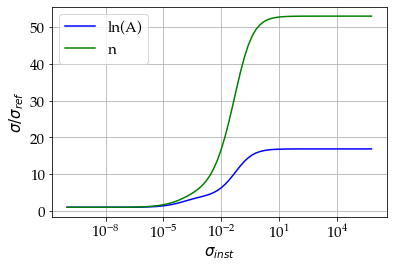

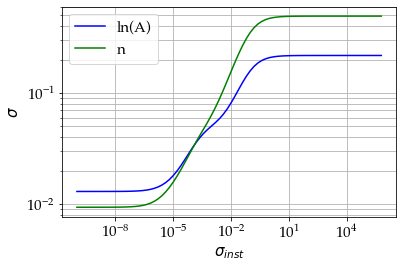

In [312]:
 # Now we plot the results. Again we make two figures, showing respectively the ratio of uncertainties 
# and the full uncertainty as a function of the magnitude of the allowed prior uncertainty in the
# instrumental noise.


#### without Galactic binaries


#### ratio of uncertainties #######


plt.figure()
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_FOPT[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_FOPT[:,1],'g-', label='n')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
#plt.xlim(1e-7, 1e4)
plt.legend()
plt.grid(True)



#### full uncertainties #######

plt.figure()
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_FOPT[:,0]),'b-', label='ln(A)')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_FOPT[:,1]),'g-', label='n  ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_FOPT[:,0],'b--', label='ln(A)  $[\sigma_{ref}]$ ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_FOPT[:,1],'g--', label='n  $[\sigma_{ref}]$')

plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
#plt.xlim(1e-7, 1e4)
plt.legend()


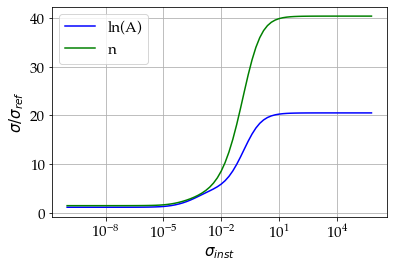

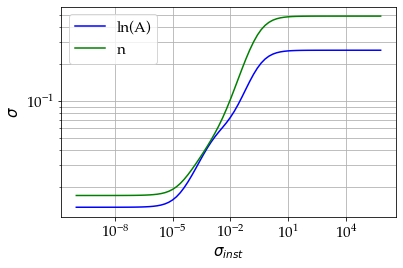

In [381]:
#### with Galactic binaries

#### ratio of uncertainties #######


plt.figure()
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_FOPT_GB[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_FOPT_GB[:,1],'g-', label='n')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
#plt.xlim(1e-7, 1e4)
plt.legend()
plt.grid(True)


#### ratio of uncertainties #######

plt.figure()
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_FOPT_GB[:,0]),'b-', label='ln(A)')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_FOPT_GB[:,1]),'g-', label='n  ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_FOPT[:,0],'b--', label='ln(A)  $[\sigma_{ref}]$ ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_FOPT[:,1],'g--', label='n  $[\sigma_{ref}]$')

plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
#plt.xlim(1e-7, 1e4)
plt.legend()
plt.grid(which = 'both')


### Gaussian bump 

In [306]:
#  --------------- #

ratio_res_array_varySig_gaussian=np.zeros(shape=(len(Spline_Uncert),Nsrc_gaussian))
full_prec_res_array_varySig_gaussian=np.zeros(shape=(len(Spline_Uncert),Nsrc_gaussian))
ref_prec_res_array_varySig_gaussian=np.zeros(shape=(len(Spline_Uncert),Nsrc_gaussian))
prior_inv_CSD_gaussian=np.zeros((Nsrc_gaussian+Ninst_CSD,Nsrc_gaussian+Ninst_CSD))

#  --------------- #

ratio_res_array_varySig_gaussian_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_gaussian))
full_prec_res_array_varySig_gaussian_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_gaussian))
ref_prec_res_array_varySig_gaussian_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_gaussian))
prior_inv_CSD_gaussian_GB=np.zeros((Nsrc_gaussian+1+Ninst_CSD,Nsrc_gaussian+1+Ninst_CSD))



# Loop over values for the uncertainty. Note the only thing that we are changing is "refsig" from 
# the previous example. This corresponds to assuming that the uncertaities at all frequencies in
# all of the PSDs is the same.



# construct prior inv

@njit
def get_prior_inv(prior_inv_CSD_gaussian,prior_inv_CSD_gaussian_GB, PSDsigs_oneChan, Nsrc_gaussian, Nch):
    for i in range(np.int(Nch*(Nch+1)/2)):
        for k in range(len(PSDsigs_oneChan)):
            # one over sigma =   1/PSDsigs_oneChan
            prior_inv_CSD_gaussian[Nsrc_gaussian+i*len(PSDsigs_oneChan)+k,Nsrc_gaussian+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            prior_inv_CSD_gaussian_GB[Nsrc_gaussian+1+i*len(PSDsigs_oneChan)+k,Nsrc_gaussian+1+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            
for j in range(len(Spline_Uncert)):
    print("completed", j/len(Spline_Uncert) )
    # refsig = e^(log(10) * Uncer) = e^( log (10^(Uncer)) ) = 10^(Uncer) = 10^(Spline_Uncert=np.arange(-10.0,6.0,0.2))
    refsig=np.exp(np.log(10.0)*Spline_Uncert[j]) # prior uncertainty value 
    PSDsigs_oneChan = np.asarray([refsig for i in range(len(PSDsigs_oneChan))])
    
    
    # get prior inv
    get_prior_inv(prior_inv_CSD_gaussian,prior_inv_CSD_gaussian_GB, PSDsigs_oneChan, Nsrc_gaussian, Nch)
    
    #############
   
    FM_gaussian_ref,FM_gaussian_full,fish_gaussian_ref_inv,fish_gaussian_full_inv,ratiores_gaussian=JointFisherMatrix(gaussian_Derivs_ref_CSD,InstAEzeta1_CSD_Derivs,gaussian_CSD_ref_Inv,prior_inv_CSD_gaussian,Nch)
   
    ratio_res_array_varySig_gaussian[j]=ratiores_gaussian
    full_prec_res_array_varySig_gaussian[j]=np.diag(np.array(fish_gaussian_full_inv.tolist()))[:Nsrc_gaussian]
    ref_prec_res_array_varySig_gaussian[j]=np.diag(np.array(fish_gaussian_ref_inv.tolist()))[:Nsrc_gaussian]
    
    #### with GB
    
    FM_gaussian_ref_GB,FM_gaussian_full_GB,fish_gaussian_ref_inv_GB,fish_gaussian_full_inv_GB,ratiores_gaussian_GB=JointFisherMatrix(gaussian_Derivs_ref_CSD,GB_CSD_noise_derivs,gaussian_CSD_ref_Inv_GB,prior_inv_CSD_gaussian_GB,Nch)
    
    ratio_res_array_varySig_gaussian_GB[j]=ratiores_gaussian_GB
    full_prec_res_array_varySig_gaussian_GB[j]=np.diag(np.array(fish_gaussian_full_inv_GB.tolist()))[:Nsrc_gaussian]
    ref_prec_res_array_varySig_gaussian_GB[j]=np.diag(np.array(fish_gaussian_ref_inv_GB.tolist()))[:Nsrc_gaussian]
    


completed 0.0


/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/383176202.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_gaussian[j]=ratiores_gaussian
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/383176202.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  full_prec_res_array_varySig_gaussian[j]=np.diag(np.array(fish_gaussian_full_inv.tolist()))[:Nsrc_gaussian]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/383176202.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  ref_prec_res_array_varySig_gaussian[j]=np.diag(np.array(fish_gaussian_ref_inv.tolist()))[:Nsrc_gaussian]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/383176202.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_gaussian2[j]=ratiores_gaussian2
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn

completed 0.0125
completed 0.025
completed 0.0375
completed 0.05
completed 0.0625
completed 0.075
completed 0.0875
completed 0.1
completed 0.1125
completed 0.125
completed 0.1375
completed 0.15
completed 0.1625
completed 0.175
completed 0.1875
completed 0.2
completed 0.2125
completed 0.225
completed 0.2375
completed 0.25
completed 0.2625
completed 0.275
completed 0.2875
completed 0.3
completed 0.3125
completed 0.325
completed 0.3375
completed 0.35
completed 0.3625
completed 0.375
completed 0.3875
completed 0.4
completed 0.4125
completed 0.425
completed 0.4375
completed 0.45
completed 0.4625
completed 0.475
completed 0.4875
completed 0.5
completed 0.5125
completed 0.525
completed 0.5375
completed 0.55
completed 0.5625
completed 0.575
completed 0.5875
completed 0.6
completed 0.6125
completed 0.625
completed 0.6375
completed 0.65
completed 0.6625
completed 0.675
completed 0.6875
completed 0.7
completed 0.7125
completed 0.725
completed 0.7375
completed 0.75
completed 0.7625
completed 0.775

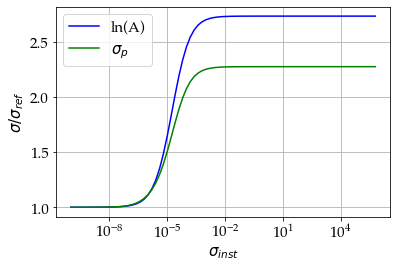

<Figure size 432x288 with 0 Axes>

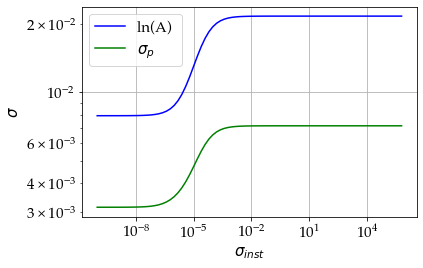

In [317]:
# Now we plot the results. Again we make two figures, showing respectively the ratio of uncertainties 
# and the full uncertainty as a function of the magnitude of the allowed prior uncertainty in the
# instrumental noise.

#### without Galactic binaries


#### ratio of uncertainties #######



plt.figure('Gaussian bump correlated ratio')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_gaussian[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_gaussian[:,1],'g-', label='${\sigma_p}$ ')
#plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_gaussian2[:,0],'r--', label='ln(A) ref')
#plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_gaussian2[:,1],'k--', label='${\sigma_p}$ ref ')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
#plt.xlim(1e-9, 1e-1)
plt.legend()
plt.grid(True)


#### full uncertainties #######

plt.figure()
plt.figure('Gaussian bump correlated')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_gaussian[:,0]),'b-', label='ln(A) ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_gaussian[:,1]),'g-', label='${\sigma_p}$  ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_gaussian2[:,0]),'r--', label='ln(A) ref')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_gaussian2[:,1]),'k--', label='${\sigma_p}$ ref ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_gaussian[:,0],'b--', label='ln(A)  $[\sigma_{ref}]$ ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_gaussian[:,1],'g--', label='${\sigma_p}$  $[\sigma_{ref}]$')

plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
plt.legend()
#plt.xlim(1e-9, 1e-1)
plt.grid(True)


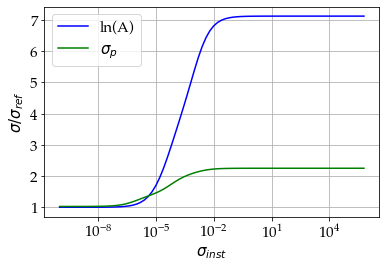

<Figure size 432x288 with 0 Axes>

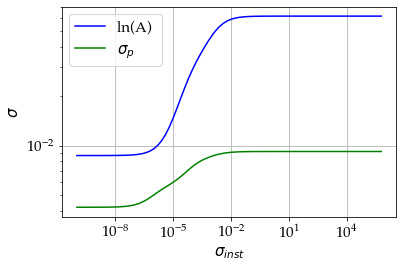

In [315]:
#### with Galactic binaries

#### ratio of uncertainties #######


plt.figure('Gaussian bump correlated ratio GB')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_gaussian_GB[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_gaussian_GB[:,1],'g-', label='${\sigma_p}$ ')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
#plt.xlim(1e-9, 1e-1)
plt.legend()
plt.grid(True)


#### full uncertainties #######

plt.figure()
plt.figure('Gaussian bump correlated GB')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_gaussian_GB[:,0]),'b-', label='ln(A) ')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_gaussian_GB[:,1]),'g-', label='${\sigma_p}$  ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_gaussian[:,0],'b--', label='ln(A)  $[\sigma_{ref}]$ ')
#plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),ref_prec_res_array_varySig_gaussian[:,1],'g--', label='${\sigma_p}$  $[\sigma_{ref}]$')

plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
plt.legend()
#plt.xlim(1e-9, 1e-1)
plt.grid(True)


### Power law with running 

In [318]:
###### ------ #######

ratio_res_array_varySig_pl_wr=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl_wr))
full_prec_res_array_varySig_pl_wr=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl_wr))
ref_prec_res_array_varySig_pl_wr=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl_wr))
prior_CSD_inv_pl_wr=np.zeros((Nsrc_pl_wr+Ninst_CSD,Nsrc_pl_wr+Ninst_CSD))

###### ------ #######

ratio_res_array_varySig_pl_wr_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl_wr))
full_prec_res_array_varySig_pl_wr_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl_wr))
ref_prec_res_array_varySig_pl_wr_GB=np.zeros(shape=(len(Spline_Uncert),Nsrc_pl_wr))
prior_CSD_inv_pl_wr_GB=np.zeros((Nsrc_pl_wr+1+Ninst_CSD,Nsrc_pl_wr+1+Ninst_CSD))




@njit
def get_prior_inv(prior_CSD_inv_pl_wr,prior_CSD_inv_pl_wr_GB, PSDsigs_oneChan, Nsrc_pl_wr, Nch):
    for i in range(np.int(Nch*(Nch+1)/2)):
        for k in range(len(PSDsigs_oneChan)):
            prior_CSD_inv_pl_wr[Nsrc_pl_wr+i*len(PSDsigs_oneChan)+k,Nsrc_pl_wr+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            prior_CSD_inv_pl_wr_GB[Nsrc_pl_wr+1+i*len(PSDsigs_oneChan)+k,Nsrc_pl_wr+1+i*len(PSDsigs_oneChan)+k]=1./PSDsigs_oneChan[k]
            

                
for j in range(len(Spline_Uncert)):
    print("completed", j/len(Spline_Uncert) )
    # refsig = e^(log(10) * Uncer) = e^( log (10^(Uncer)) ) = 10^(Uncer) = 10^(Spline_Uncert=np.arange(-10.0,6.0,0.2))
    refsig=np.exp(np.log(10.0)*Spline_Uncert[j]) # prior uncertainty value 
    PSDsigs_oneChan = np.asarray([refsig for i in range(len(PSDsigs_oneChan))])
    # get prior inv
    get_prior_inv(prior_CSD_inv_pl_wr,prior_CSD_inv_pl_wr_GB, PSDsigs_oneChan, Nsrc_pl_wr, Nch)
    
    ######################
    
    FM_pl_wr_ref,FM_pl_wr_full_ref,fish_pl_wr_inv_ref,fish_pl_wr_full_inv_ref,ratiores_pl_wr_ref=JointFisherMatrix(powerlaw_wr_Derivs_ref_CSD,InstAEzeta1_CSD_Derivs, powerlaw_wr_CSD_ref_Inv,prior_CSD_inv_pl_wr,Nch)
   
    ratio_res_array_varySig_pl_wr[j]=ratiores_pl_wr_ref
    full_prec_res_array_varySig_pl_wr[j]=np.diag(np.array(fish_pl_wr_full_inv_ref.tolist()))[:Nsrc_pl_wr]
    ref_prec_res_array_varySig_pl_wr[j]=np.diag(np.array(fish_pl_wr_inv_ref.tolist()))[:Nsrc_pl_wr]
    
    #### with GB
    
    FM_pl_wr_ref_GB,FM_pl_wr_full_ref_GB,fish_pl_wr_inv_ref_GB,fish_pl_wr_full_inv_ref_GB,ratiores_pl_wr_ref_GB=JointFisherMatrix(powerlaw_wr_Derivs_ref_CSD,GB_CSD_noise_derivs, powerlaw_wr_CSD_ref_Inv_GB,prior_CSD_inv_pl_wr_GB,Nch)

    ratio_res_array_varySig_pl_wr_GB[j]=ratiores_pl_wr_ref_GB
    full_prec_res_array_varySig_pl_wr_GB[j]=np.diag(np.array(fish_pl_wr_full_inv_ref_GB.tolist()))[:Nsrc_pl_wr]
    ref_prec_res_array_varySig_pl_wr_GB[j]=np.diag(np.array(fish_pl_wr_inv_ref_GB.tolist()))[:Nsrc_pl_wr]
    

completed 0.0


/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/1458875354.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_pl_wr[j]=ratiores_pl_wr_ref
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/1458875354.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  full_prec_res_array_varySig_pl_wr[j]=np.diag(np.array(fish_pl_wr_full_inv_ref.tolist()))[:Nsrc_pl_wr]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/1458875354.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  ref_prec_res_array_varySig_pl_wr[j]=np.diag(np.array(fish_pl_wr_inv_ref.tolist()))[:Nsrc_pl_wr]
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykernel_4409/1458875354.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  ratio_res_array_varySig_pl_wr_GB[j]=ratiores_pl_wr_ref_GB
/var/folders/nx/v5jjl8rn6pb350pn_bmr0y8r0000gn/T/ipykern

completed 0.0125
completed 0.025
completed 0.0375
completed 0.05
completed 0.0625
completed 0.075
completed 0.0875
completed 0.1
completed 0.1125
completed 0.125
completed 0.1375
completed 0.15
completed 0.1625
completed 0.175
completed 0.1875
completed 0.2
completed 0.2125
completed 0.225
completed 0.2375
completed 0.25
completed 0.2625
completed 0.275
completed 0.2875
completed 0.3
completed 0.3125
completed 0.325
completed 0.3375
completed 0.35
completed 0.3625
completed 0.375
completed 0.3875
completed 0.4
completed 0.4125
completed 0.425
completed 0.4375
completed 0.45
completed 0.4625
completed 0.475
completed 0.4875
completed 0.5
completed 0.5125
completed 0.525
completed 0.5375
completed 0.55
completed 0.5625
completed 0.575
completed 0.5875
completed 0.6
completed 0.6125
completed 0.625
completed 0.6375
completed 0.65
completed 0.6625
completed 0.675
completed 0.6875
completed 0.7
completed 0.7125
completed 0.725
completed 0.7375
completed 0.75
completed 0.7625
completed 0.775

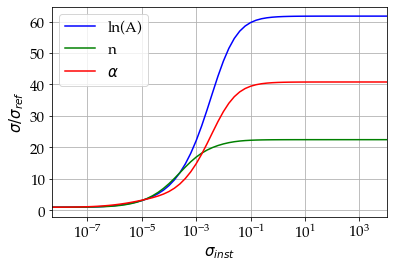

<Figure size 432x288 with 0 Axes>

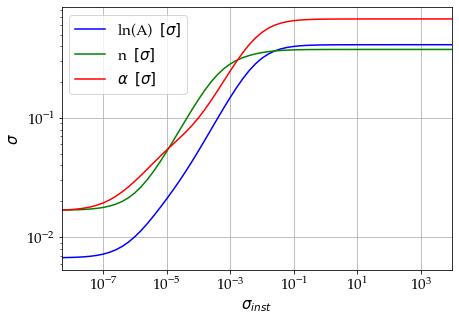

In [319]:
# Now we plot the results. Again we make two figures, showing respectively the ratio of uncertainties 
# and the full uncertainty as a function of the magnitude of the allowed prior uncertainty in the
# instrumental noise.

##### without galactic binaries

#### ratio of uncertainties #######


plt.figure('PL with running ratio')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_wr[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_wr[:,1],'g-', label='n')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_wr[:,2],'r-', label='$\\alpha$')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
plt.xlim(5e-9, 1e4)
plt.legend()
plt.grid(True)



#### full uncertainties #######


plt.figure('PL with running')
plt.figure(figsize=(7,5))
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_wr[:,0]),'b-', label='ln(A)  $[\sigma]$')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_wr[:,1]),'g-', label='n  $[\sigma]$')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_wr[:,2]),'r-', label='$\\alpha$  $[\sigma]$')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
plt.xlim(5e-9, 1e4)
plt.legend()
plt.grid(True)




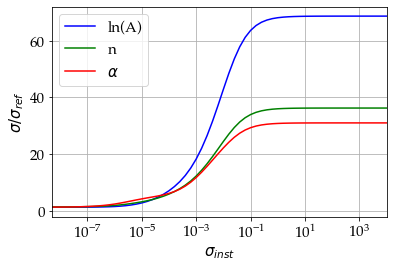

<Figure size 432x288 with 0 Axes>

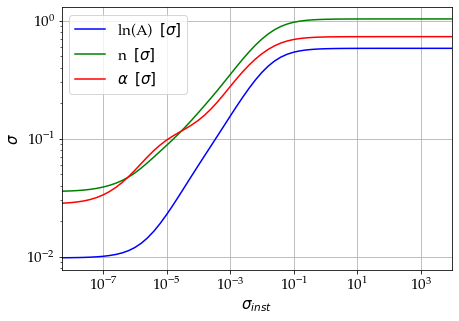

In [320]:
#### with galactic binaries

#### ratio of uncertainties #######

plt.figure('PL with running ratio GB')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_wr_GB[:,0],'b-', label='ln(A)')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_wr_GB[:,1],'g-', label='n')
plt.semilogx(np.exp(np.log(10.0)*Spline_Uncert),ratio_res_array_varySig_pl_wr_GB[:,2],'r-', label='$\\alpha$')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma/\sigma_{ref}$')
plt.xlim(5e-9, 1e4)
plt.legend()
plt.grid(True)

#### full uncertainties #######


plt.figure('PL with running GB')
plt.figure(figsize=(7,5))
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_wr_GB[:,0]),'b-', label='ln(A)  $[\sigma]$')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_wr_GB[:,1]),'g-', label='n  $[\sigma]$')
plt.loglog(np.exp(np.log(10.0)*Spline_Uncert),np.sqrt(full_prec_res_array_varySig_pl_wr_GB[:,2]),'r-', label='$\\alpha$  $[\sigma]$')
plt.subplots_adjust(bottom=0.15)
plt.xlabel('$\sigma_{inst}$')
plt.ylabel('$\sigma$')
plt.xlim(5e-9, 1e4)
plt.legend()
plt.grid(True)
